In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from utils import load_all_batches
from itertools import product


# Meine Dataset Klasse
class GasSensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-np.log(10000.0) / model_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        # x: (batch_size, seq_len, model_dim)
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

In [3]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, model_dim=64, n_heads=4, num_layers=2, dim_feedforward=128, lr=0.001):
        super(TimeSeriesTransformer, self).__init__()
        self.model_dim = model_dim

        # Pos Encoding
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Klassifikation
        self.classifier = nn.Linear(model_dim, num_classes)

        # Loss und Optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1) # Macht eine global avg Pooling über Sequenz
        out = self.classifier(x)
        return out
    
    def train_step(self, batch):
        self.optimizer.zero_grad()
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()


    def test_step(self, batch):
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        return loss.item()
        

    def plot_loss(self, train_losses, test_losses):
        epochs = len(train_losses)
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), train_losses, marker='o', label="Train Loss")
        plt.plot(range(1, epochs+1), test_losses, marker='o', color='red', label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average Loss")
        plt.title("Training vs Test Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    def train_model(self, train_loader, test_loader, epochs):
        all_train_losses = []
        all_test_losses = []
        
        for epoch in range(epochs):
            # Training 
            total_loss = 0
            for batch in train_loader:
                loss = self.train_step(batch)
                total_loss += loss
            avg_train_loss = total_loss / len(train_loader)
            all_train_losses.append(avg_train_loss)
        
            # Testen / Validieren
            total_test_loss = 0
            with torch.no_grad():  # keine Gradienten beim Testen
                for batch in test_loader:
                    loss = self.test_step(batch)  # oder self.train_step(batch) im eval-Modus
                    total_test_loss += loss
            avg_test_loss = total_test_loss / len(test_loader)
            all_test_losses.append(avg_test_loss)
        
            print(f"Epoch [{epoch+1}/{epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Test Loss: {avg_test_loss:.4f}")
        
        self.plot_loss(all_train_losses, all_test_losses)
        
        return all_train_losses, all_test_losses


    def evaluate(self, test_loader):
        self.eval()
        correct, total = 0, 0
        device = next(self.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = self(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        self.train()
        return accuracy

    def save(self, path):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")

    def load(self, path):
        self.load_state_dict(torch.load(path, map_location=map_location))
        print(f"Model loaded from {path}")

In [4]:
# Datenvorbereitung

folderpath = r"gas+sensor+array+drift+dataset\Dataset"
df = load_all_batches(folderpath)

X = df.iloc[:, 0:128].values
y = df.iloc[:, 128].values

scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


SEQ_LEN = 50

def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
       xs.append(X[i:i+seq_len])
       ys.append(y[i+seq_len-1] - 1)
    return np.array(xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, SEQ_LEN)

train_dataset = GasSensorDataset(X_train_seq, y_train_seq)
test_dataset = GasSensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Using device: cuda
Epoch [1/30] | Train Loss: 1.7857 | Test Loss: 1.7825
Epoch [2/30] | Train Loss: 0.9301 | Test Loss: 0.5420
Epoch [3/30] | Train Loss: 0.3549 | Test Loss: 0.3246
Epoch [4/30] | Train Loss: 0.2083 | Test Loss: 0.1706
Epoch [5/30] | Train Loss: 0.1697 | Test Loss: 0.1678
Epoch [6/30] | Train Loss: 0.1565 | Test Loss: 0.1333
Epoch [7/30] | Train Loss: 0.1285 | Test Loss: 0.1494
Epoch [8/30] | Train Loss: 0.1300 | Test Loss: 0.1419
Epoch [9/30] | Train Loss: 0.1160 | Test Loss: 0.1341
Epoch [10/30] | Train Loss: 0.1218 | Test Loss: 0.1551
Epoch [11/30] | Train Loss: 0.1126 | Test Loss: 0.1178
Epoch [12/30] | Train Loss: 0.1066 | Test Loss: 0.1440
Epoch [13/30] | Train Loss: 0.1161 | Test Loss: 0.0828
Epoch [14/30] | Train Loss: 0.0818 | Test Loss: 0.1561
Epoch [15/30] | Train Loss: 0.0827 | Test Loss: 0.1230
Epoch [16/30] | Train Loss: 0.0963 | Test Loss: 0.0720
Epoch [17/30] | Train Loss: 0.0810 | Test Loss: 0.1062
Epoch [18/30] | Train Loss: 0.0736 | Test Loss: 0.1147


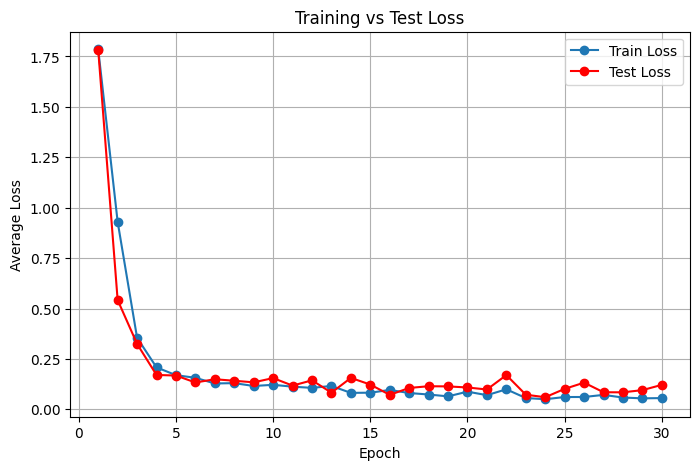

Test Accuracy: 0.9726
Test Accuracy: 0.9726
True: Acetone, Predicted: Acetone
True: Methane, Predicted: Methane
True: Acetone, Predicted: Acetone
True: Toluene, Predicted: Toluene
True: Acetone, Predicted: Acetone
True: Methane, Predicted: Methane
True: Ammonia, Predicted: Ammonia
True: Methane, Predicted: Methane
True: Acetone, Predicted: Acetone
True: Benzene, Predicted: Benzene
True: Toluene, Predicted: Toluene
True: Acetone, Predicted: Acetone
True: Ammonia, Predicted: Ammonia
True: Ammonia, Predicted: Ammonia
True: Acetone, Predicted: Acetone
True: Benzene, Predicted: Acetone
True: Methane, Predicted: Methane
True: Benzene, Predicted: Benzene
True: Methane, Predicted: Methane
True: Acetone, Predicted: Acetone
Model saved to transformer_batch1.pth


In [8]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Old params: 64, 4, 2
model = TimeSeriesTransformer(input_dim=128, num_classes=6, model_dim=128, n_heads=16, num_layers=2)
model.to(device)

model.train_model(train_loader, test_loader, epochs=30)
model.evaluate(test_loader)


# Vorhersage der Gasarten-Namen
gas_labels = ["Ammonia", "Acetone", "Benzene", "Ethylene", "Methane", "Toluene"]

model.eval()

all_preds = [] # Vorhersagen
all_labels = [] # Echte Labels

with torch.no_grad(): # Schalte Gradient Tracking aus
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Accuracy berechnen
correct = sum(p == t for p, t in zip(all_preds, all_labels))
accuracy = correct / len(all_labels)
print(f"Test Accuracy: {accuracy:.4f}")

for true_idx, pred_idx in zip(all_labels[:20], all_preds[:20]):
    print(f"True: {gas_labels[true_idx]}, Predicted: {gas_labels[pred_idx]}")


model.save("transformer_batch1.pth")


--- Fold 1/5 ---
Epoch [1/30], Loss: 1.7353
Epoch [2/30], Loss: 1.4604
Epoch [3/30], Loss: 1.1365
Epoch [4/30], Loss: 0.8969
Epoch [5/30], Loss: 0.7583
Epoch [6/30], Loss: 0.6405
Epoch [7/30], Loss: 0.5497
Epoch [8/30], Loss: 0.4594
Epoch [9/30], Loss: 0.3747
Epoch [10/30], Loss: 0.3260
Epoch [11/30], Loss: 0.2773
Epoch [12/30], Loss: 0.2365
Epoch [13/30], Loss: 0.2358
Epoch [14/30], Loss: 0.2038
Epoch [15/30], Loss: 0.1847
Epoch [16/30], Loss: 0.1525
Epoch [17/30], Loss: 0.1122
Epoch [18/30], Loss: 0.1064
Epoch [19/30], Loss: 0.0807
Epoch [20/30], Loss: 0.0652
Epoch [21/30], Loss: 0.0583
Epoch [22/30], Loss: 0.0468
Epoch [23/30], Loss: 0.0535
Epoch [24/30], Loss: 0.0644
Epoch [25/30], Loss: 0.0445
Epoch [26/30], Loss: 0.0431
Epoch [27/30], Loss: 0.0374
Epoch [28/30], Loss: 0.0454
Epoch [29/30], Loss: 0.0296
Epoch [30/30], Loss: 0.0287


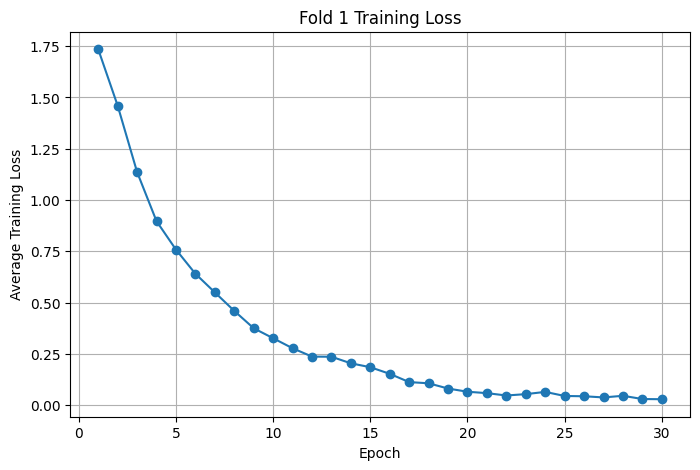

Test Accuracy: 0.9750

--- Fold 2/5 ---
Epoch [1/30], Loss: 1.7200
Epoch [2/30], Loss: 1.4385
Epoch [3/30], Loss: 1.1333
Epoch [4/30], Loss: 0.9323
Epoch [5/30], Loss: 0.7904
Epoch [6/30], Loss: 0.6720
Epoch [7/30], Loss: 0.5586
Epoch [8/30], Loss: 0.4594
Epoch [9/30], Loss: 0.3965
Epoch [10/30], Loss: 0.3359
Epoch [11/30], Loss: 0.3100
Epoch [12/30], Loss: 0.2717
Epoch [13/30], Loss: 0.2356
Epoch [14/30], Loss: 0.1976
Epoch [15/30], Loss: 0.1777
Epoch [16/30], Loss: 0.1595
Epoch [17/30], Loss: 0.1411
Epoch [18/30], Loss: 0.1074
Epoch [19/30], Loss: 0.0892
Epoch [20/30], Loss: 0.0860
Epoch [21/30], Loss: 0.0683
Epoch [22/30], Loss: 0.0585
Epoch [23/30], Loss: 0.0482
Epoch [24/30], Loss: 0.0459
Epoch [25/30], Loss: 0.0356
Epoch [26/30], Loss: 0.0336
Epoch [27/30], Loss: 0.0411
Epoch [28/30], Loss: 0.0341
Epoch [29/30], Loss: 0.0598
Epoch [30/30], Loss: 0.0843


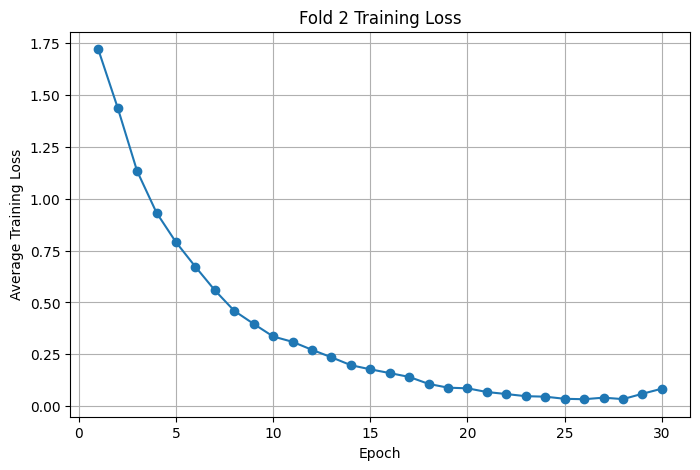

Test Accuracy: 1.0000

--- Fold 3/5 ---
Epoch [1/30], Loss: 1.6135
Epoch [2/30], Loss: 1.2512
Epoch [3/30], Loss: 0.9699
Epoch [4/30], Loss: 0.8030
Epoch [5/30], Loss: 0.6631
Epoch [6/30], Loss: 0.5447
Epoch [7/30], Loss: 0.4733
Epoch [8/30], Loss: 0.3849
Epoch [9/30], Loss: 0.3259
Epoch [10/30], Loss: 0.2986
Epoch [11/30], Loss: 0.2769
Epoch [12/30], Loss: 0.2064
Epoch [13/30], Loss: 0.1764
Epoch [14/30], Loss: 0.1511
Epoch [15/30], Loss: 0.1464
Epoch [16/30], Loss: 0.1325
Epoch [17/30], Loss: 0.1280
Epoch [18/30], Loss: 0.0940
Epoch [19/30], Loss: 0.0768
Epoch [20/30], Loss: 0.0759
Epoch [21/30], Loss: 0.0613
Epoch [22/30], Loss: 0.0437
Epoch [23/30], Loss: 0.0551
Epoch [24/30], Loss: 0.0455
Epoch [25/30], Loss: 0.0425
Epoch [26/30], Loss: 0.0343
Epoch [27/30], Loss: 0.0354
Epoch [28/30], Loss: 0.0398
Epoch [29/30], Loss: 0.0412
Epoch [30/30], Loss: 0.0294


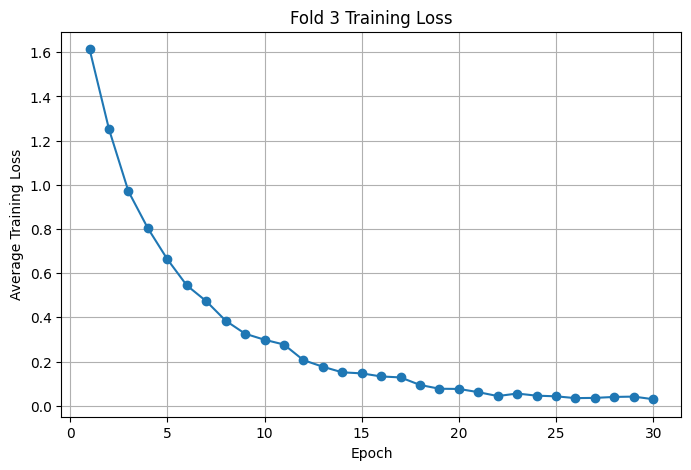

Test Accuracy: 0.9494

--- Fold 4/5 ---
Epoch [1/30], Loss: 1.6931
Epoch [2/30], Loss: 1.2989
Epoch [3/30], Loss: 0.9948
Epoch [4/30], Loss: 0.8027
Epoch [5/30], Loss: 0.6848
Epoch [6/30], Loss: 0.5875
Epoch [7/30], Loss: 0.5096
Epoch [8/30], Loss: 0.4179
Epoch [9/30], Loss: 0.3473
Epoch [10/30], Loss: 0.2994
Epoch [11/30], Loss: 0.2631
Epoch [12/30], Loss: 0.2215
Epoch [13/30], Loss: 0.1974
Epoch [14/30], Loss: 0.1643
Epoch [15/30], Loss: 0.1461
Epoch [16/30], Loss: 0.1239
Epoch [17/30], Loss: 0.1164
Epoch [18/30], Loss: 0.0762
Epoch [19/30], Loss: 0.0785
Epoch [20/30], Loss: 0.0639
Epoch [21/30], Loss: 0.0537
Epoch [22/30], Loss: 0.0521
Epoch [23/30], Loss: 0.0450
Epoch [24/30], Loss: 0.0285
Epoch [25/30], Loss: 0.0338
Epoch [26/30], Loss: 0.0317
Epoch [27/30], Loss: 0.0320
Epoch [28/30], Loss: 0.0228
Epoch [29/30], Loss: 0.0170
Epoch [30/30], Loss: 0.0273


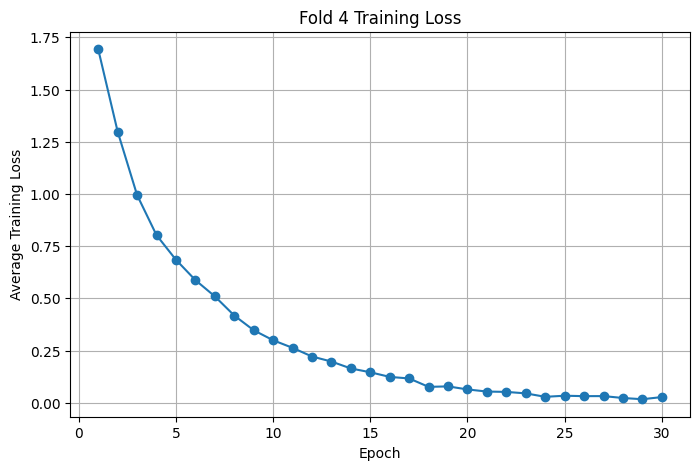

Test Accuracy: 0.9747

--- Fold 5/5 ---
Epoch [1/30], Loss: 1.6737
Epoch [2/30], Loss: 1.3098
Epoch [3/30], Loss: 1.0037
Epoch [4/30], Loss: 0.8223
Epoch [5/30], Loss: 0.6857
Epoch [6/30], Loss: 0.5731
Epoch [7/30], Loss: 0.4857
Epoch [8/30], Loss: 0.4203
Epoch [9/30], Loss: 0.3547
Epoch [10/30], Loss: 0.3038
Epoch [11/30], Loss: 0.2571
Epoch [12/30], Loss: 0.2211
Epoch [13/30], Loss: 0.1890
Epoch [14/30], Loss: 0.1666
Epoch [15/30], Loss: 0.1418
Epoch [16/30], Loss: 0.1249
Epoch [17/30], Loss: 0.1199
Epoch [18/30], Loss: 0.0983
Epoch [19/30], Loss: 0.1052
Epoch [20/30], Loss: 0.0898
Epoch [21/30], Loss: 0.0718
Epoch [22/30], Loss: 0.0602
Epoch [23/30], Loss: 0.0469
Epoch [24/30], Loss: 0.0441
Epoch [25/30], Loss: 0.0366
Epoch [26/30], Loss: 0.0305
Epoch [27/30], Loss: 0.0261
Epoch [28/30], Loss: 0.0226
Epoch [29/30], Loss: 0.0210
Epoch [30/30], Loss: 0.0235


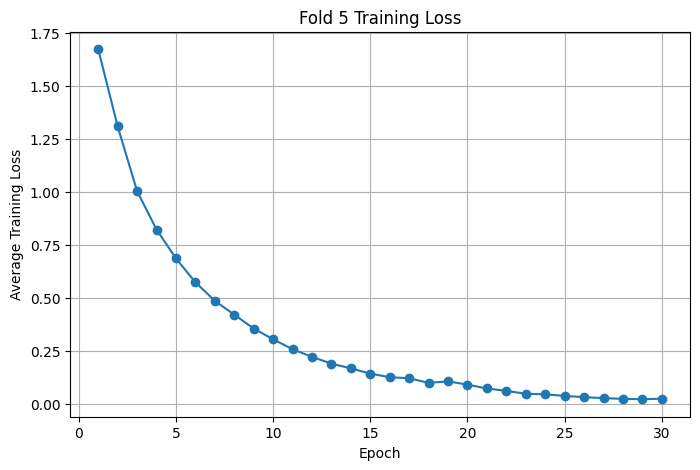

Test Accuracy: 0.9873

Average Accuracy across 5 folds: 0.9773


In [24]:
# NEU: 5-Fold Cross Validation

EPOCHS = 30

# Sequenzen einmal erstellen
X_seq, y_seq = create_sequences(X, y, SEQ_LEN)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\n--- Fold {fold+1}/5 ---")
    
    # Fold-Daten
    X_train_fold, y_train_fold = X_seq[train_idx], y_seq[train_idx]
    X_val_fold, y_val_fold = X_seq[val_idx], y_seq[val_idx]
    
    train_dataset = GasSensorDataset(X_train_fold, y_train_fold)
    val_dataset = GasSensorDataset(X_val_fold, y_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    # Neues Modell pro Fold
    model = TimeSeriesTransformer(input_dim=128, num_classes=6,
                                  model_dim=64, n_heads=4,
                                  num_layers=2, lr=0.001)
    model.to(device)
    
    # Training + Loss speichern
    all_losses = []
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in train_loader:
            loss = model.train_step(batch)
            total_loss += loss
        avg_loss = total_loss / len(train_loader)
        all_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")
    
    # Loss-Kurve plotten
    plt.figure(figsize=(8,5))
    plt.plot(range(1, EPOCHS+1), all_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Average Training Loss")
    plt.title(f"Fold {fold+1} Training Loss")
    plt.grid(True)
    plt.show()
    
    # Evaluation 
    acc = model.evaluate(val_loader)
    fold_accuracies.append(acc)

# Durchschnittliche Accuracy der folds
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across 5 folds: {avg_acc:.4f}")


Testing params: n_heads=2, num_layers=1, model_dim=32
Epoch [1/30] | Train Loss: 1.7734 | Test Loss: 1.7690
Epoch [2/30] | Train Loss: 1.7393 | Test Loss: 1.4059
Epoch [3/30] | Train Loss: 1.0212 | Test Loss: 0.8689
Epoch [4/30] | Train Loss: 0.5201 | Test Loss: 0.4049
Epoch [5/30] | Train Loss: 0.3857 | Test Loss: 0.3764
Epoch [6/30] | Train Loss: 0.3426 | Test Loss: 0.2772
Epoch [7/30] | Train Loss: 0.2738 | Test Loss: 0.2485
Epoch [8/30] | Train Loss: 0.2357 | Test Loss: 0.6720
Epoch [9/30] | Train Loss: 0.2381 | Test Loss: 0.6283
Epoch [10/30] | Train Loss: 0.2201 | Test Loss: 0.1737
Epoch [11/30] | Train Loss: 0.1932 | Test Loss: 0.1576
Epoch [12/30] | Train Loss: 0.1668 | Test Loss: 0.1524
Epoch [13/30] | Train Loss: 0.1919 | Test Loss: 0.1411
Epoch [14/30] | Train Loss: 0.1669 | Test Loss: 0.1713
Epoch [15/30] | Train Loss: 0.1595 | Test Loss: 0.1278
Epoch [16/30] | Train Loss: 0.1366 | Test Loss: 0.1517
Epoch [17/30] | Train Loss: 0.1424 | Test Loss: 0.1665
Epoch [18/30] | Tra

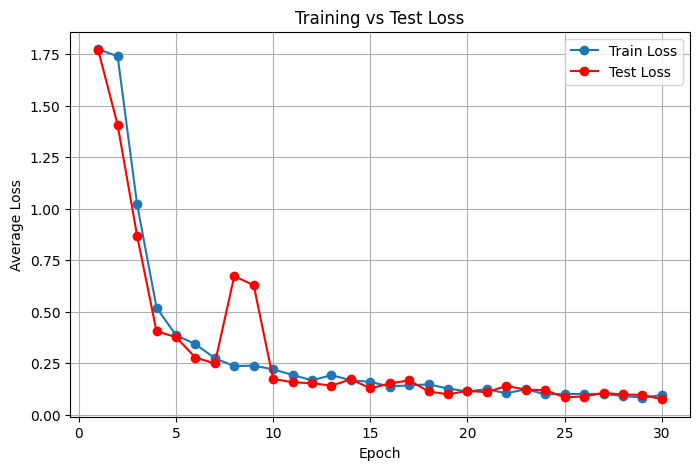

Test Accuracy: 0.9795

Testing params: n_heads=2, num_layers=1, model_dim=64
Epoch [1/30] | Train Loss: 1.7711 | Test Loss: 1.7061
Epoch [2/30] | Train Loss: 1.1652 | Test Loss: 0.8633
Epoch [3/30] | Train Loss: 0.6611 | Test Loss: 0.5416
Epoch [4/30] | Train Loss: 0.4479 | Test Loss: 0.9167
Epoch [5/30] | Train Loss: 0.3599 | Test Loss: 0.5256
Epoch [6/30] | Train Loss: 0.2896 | Test Loss: 0.3782
Epoch [7/30] | Train Loss: 0.2599 | Test Loss: 0.4787
Epoch [8/30] | Train Loss: 0.2461 | Test Loss: 0.2294
Epoch [9/30] | Train Loss: 0.2111 | Test Loss: 0.2664
Epoch [10/30] | Train Loss: 0.1733 | Test Loss: 0.1844
Epoch [11/30] | Train Loss: 0.1657 | Test Loss: 0.2443
Epoch [12/30] | Train Loss: 0.1510 | Test Loss: 0.1387
Epoch [13/30] | Train Loss: 0.1676 | Test Loss: 0.2805
Epoch [14/30] | Train Loss: 0.1317 | Test Loss: 0.1588
Epoch [15/30] | Train Loss: 0.1190 | Test Loss: 0.1477
Epoch [16/30] | Train Loss: 0.1236 | Test Loss: 0.1688
Epoch [17/30] | Train Loss: 0.1189 | Test Loss: 0.11

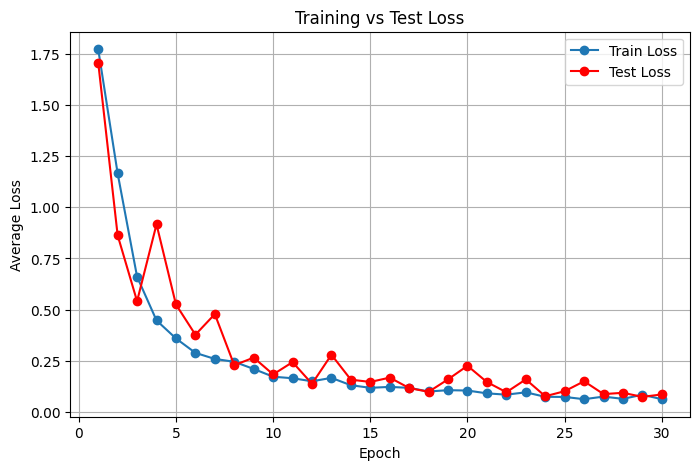

Test Accuracy: 0.9780

Testing params: n_heads=2, num_layers=1, model_dim=128
Epoch [1/30] | Train Loss: 1.3700 | Test Loss: 0.7709
Epoch [2/30] | Train Loss: 0.5677 | Test Loss: 0.5143
Epoch [3/30] | Train Loss: 0.4286 | Test Loss: 0.3675
Epoch [4/30] | Train Loss: 0.3797 | Test Loss: 0.7964
Epoch [5/30] | Train Loss: 0.3608 | Test Loss: 0.4588
Epoch [6/30] | Train Loss: 0.2944 | Test Loss: 0.2734
Epoch [7/30] | Train Loss: 0.2257 | Test Loss: 0.3517
Epoch [8/30] | Train Loss: 0.2024 | Test Loss: 0.1631
Epoch [9/30] | Train Loss: 0.1953 | Test Loss: 0.2527
Epoch [10/30] | Train Loss: 0.1926 | Test Loss: 0.1664
Epoch [11/30] | Train Loss: 0.1659 | Test Loss: 0.1864
Epoch [12/30] | Train Loss: 0.1496 | Test Loss: 0.2398
Epoch [13/30] | Train Loss: 0.1443 | Test Loss: 0.3471
Epoch [14/30] | Train Loss: 0.1483 | Test Loss: 0.2947
Epoch [15/30] | Train Loss: 0.1465 | Test Loss: 0.1402
Epoch [16/30] | Train Loss: 0.1246 | Test Loss: 0.1966
Epoch [17/30] | Train Loss: 0.1383 | Test Loss: 0.2

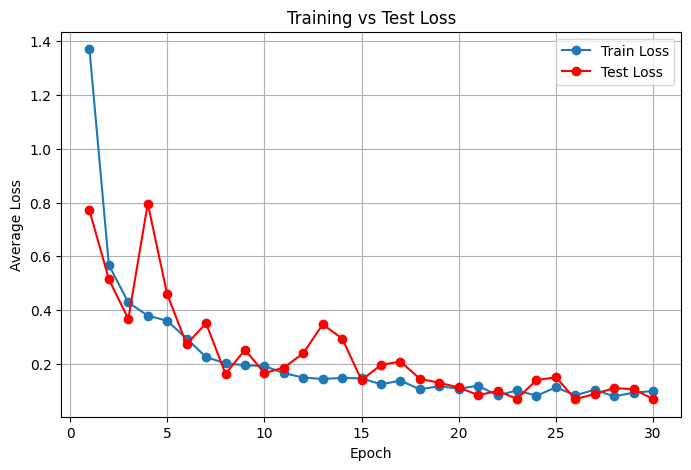

Test Accuracy: 0.9832

Testing params: n_heads=2, num_layers=1, model_dim=256
Epoch [1/30] | Train Loss: 1.2017 | Test Loss: 0.7574
Epoch [2/30] | Train Loss: 0.4732 | Test Loss: 0.4087
Epoch [3/30] | Train Loss: 0.3155 | Test Loss: 0.3625
Epoch [4/30] | Train Loss: 0.2380 | Test Loss: 0.2332
Epoch [5/30] | Train Loss: 0.2339 | Test Loss: 0.1555
Epoch [6/30] | Train Loss: 0.2001 | Test Loss: 0.1888
Epoch [7/30] | Train Loss: 0.1900 | Test Loss: 0.0948
Epoch [8/30] | Train Loss: 0.1407 | Test Loss: 0.0992
Epoch [9/30] | Train Loss: 0.1743 | Test Loss: 0.1506
Epoch [10/30] | Train Loss: 0.1031 | Test Loss: 0.0967
Epoch [11/30] | Train Loss: 0.1675 | Test Loss: 0.1257
Epoch [12/30] | Train Loss: 0.1445 | Test Loss: 0.1939
Epoch [13/30] | Train Loss: 0.1300 | Test Loss: 0.8069
Epoch [14/30] | Train Loss: 0.1311 | Test Loss: 0.0847
Epoch [15/30] | Train Loss: 0.1117 | Test Loss: 0.1463
Epoch [16/30] | Train Loss: 0.0991 | Test Loss: 0.1481
Epoch [17/30] | Train Loss: 0.1082 | Test Loss: 0.0

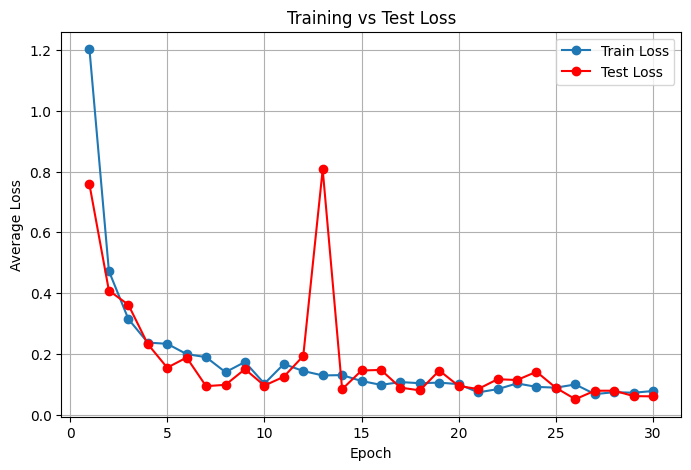

Test Accuracy: 0.9802

Testing params: n_heads=2, num_layers=2, model_dim=32
Epoch [1/30] | Train Loss: 1.7745 | Test Loss: 1.7750
Epoch [2/30] | Train Loss: 1.7703 | Test Loss: 1.7672
Epoch [3/30] | Train Loss: 1.7682 | Test Loss: 1.7719
Epoch [4/30] | Train Loss: 1.4435 | Test Loss: 1.1528
Epoch [5/30] | Train Loss: 0.6881 | Test Loss: 0.6913
Epoch [6/30] | Train Loss: 0.4376 | Test Loss: 0.3223
Epoch [7/30] | Train Loss: 0.2927 | Test Loss: 0.6001
Epoch [8/30] | Train Loss: 0.2643 | Test Loss: 0.2564
Epoch [9/30] | Train Loss: 0.2170 | Test Loss: 0.1716
Epoch [10/30] | Train Loss: 0.1764 | Test Loss: 0.1521
Epoch [11/30] | Train Loss: 0.1570 | Test Loss: 0.1512
Epoch [12/30] | Train Loss: 0.1440 | Test Loss: 0.1778
Epoch [13/30] | Train Loss: 0.1423 | Test Loss: 0.1369
Epoch [14/30] | Train Loss: 0.1227 | Test Loss: 0.1357
Epoch [15/30] | Train Loss: 0.1149 | Test Loss: 0.1868
Epoch [16/30] | Train Loss: 0.1043 | Test Loss: 0.1052
Epoch [17/30] | Train Loss: 0.1225 | Test Loss: 0.09

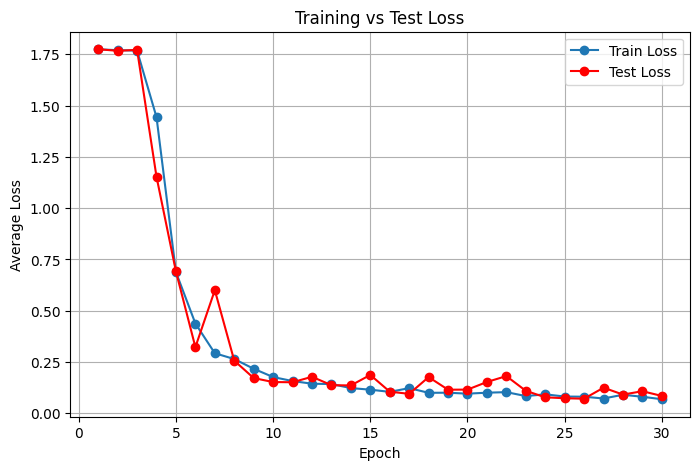

Test Accuracy: 0.9850

Testing params: n_heads=2, num_layers=2, model_dim=64
Epoch [1/30] | Train Loss: 1.7784 | Test Loss: 1.7543
Epoch [2/30] | Train Loss: 1.1103 | Test Loss: 1.0111
Epoch [3/30] | Train Loss: 0.5590 | Test Loss: 0.7062
Epoch [4/30] | Train Loss: 0.3311 | Test Loss: 0.2510
Epoch [5/30] | Train Loss: 0.2433 | Test Loss: 0.2007
Epoch [6/30] | Train Loss: 0.1798 | Test Loss: 0.1444
Epoch [7/30] | Train Loss: 0.1643 | Test Loss: 0.5928
Epoch [8/30] | Train Loss: 0.1574 | Test Loss: 0.1293
Epoch [9/30] | Train Loss: 0.1525 | Test Loss: 0.1598
Epoch [10/30] | Train Loss: 0.1382 | Test Loss: 0.1181
Epoch [11/30] | Train Loss: 0.1116 | Test Loss: 0.1151
Epoch [12/30] | Train Loss: 0.1068 | Test Loss: 0.1147
Epoch [13/30] | Train Loss: 0.1142 | Test Loss: 0.1186
Epoch [14/30] | Train Loss: 0.1031 | Test Loss: 0.0886
Epoch [15/30] | Train Loss: 0.0945 | Test Loss: 0.1300
Epoch [16/30] | Train Loss: 0.0996 | Test Loss: 0.1241
Epoch [17/30] | Train Loss: 0.0932 | Test Loss: 0.09

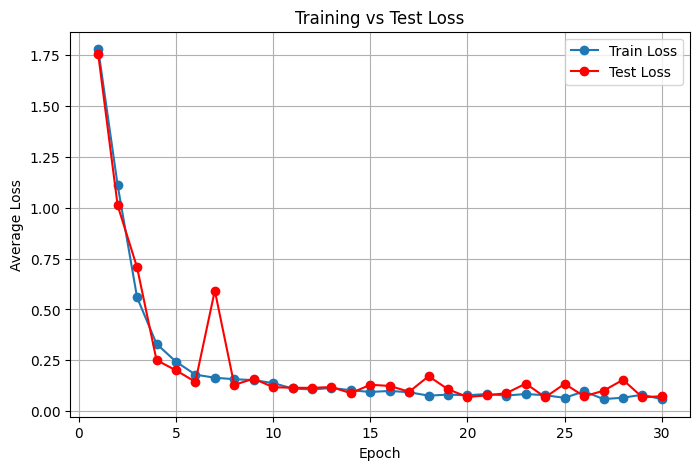

Test Accuracy: 0.9762

Testing params: n_heads=2, num_layers=2, model_dim=128
Epoch [1/30] | Train Loss: 1.7390 | Test Loss: 1.3945
Epoch [2/30] | Train Loss: 0.7531 | Test Loss: 0.8707
Epoch [3/30] | Train Loss: 0.4003 | Test Loss: 0.2769
Epoch [4/30] | Train Loss: 0.2856 | Test Loss: 0.3026
Epoch [5/30] | Train Loss: 0.2477 | Test Loss: 0.3278
Epoch [6/30] | Train Loss: 0.2164 | Test Loss: 0.1741
Epoch [7/30] | Train Loss: 0.1921 | Test Loss: 0.2250
Epoch [8/30] | Train Loss: 0.1686 | Test Loss: 0.1614
Epoch [9/30] | Train Loss: 0.1494 | Test Loss: 0.1550
Epoch [10/30] | Train Loss: 0.1322 | Test Loss: 0.1445
Epoch [11/30] | Train Loss: 0.1599 | Test Loss: 0.1183
Epoch [12/30] | Train Loss: 0.1192 | Test Loss: 0.1373
Epoch [13/30] | Train Loss: 0.1329 | Test Loss: 0.3572
Epoch [14/30] | Train Loss: 0.1404 | Test Loss: 0.1272
Epoch [15/30] | Train Loss: 0.1598 | Test Loss: 0.1374
Epoch [16/30] | Train Loss: 0.1282 | Test Loss: 0.0992
Epoch [17/30] | Train Loss: 0.1028 | Test Loss: 0.1

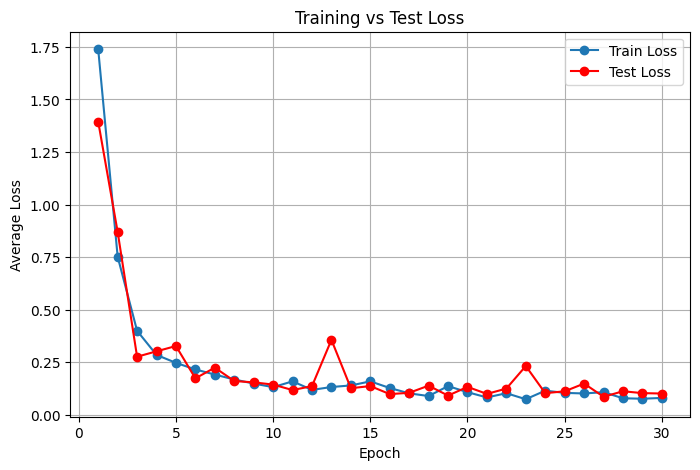

Test Accuracy: 0.9718

Testing params: n_heads=2, num_layers=2, model_dim=256
Epoch [1/30] | Train Loss: 1.8056 | Test Loss: 1.6814
Epoch [2/30] | Train Loss: 1.1190 | Test Loss: 1.1443
Epoch [3/30] | Train Loss: 0.5627 | Test Loss: 0.4489
Epoch [4/30] | Train Loss: 0.3711 | Test Loss: 0.4015
Epoch [5/30] | Train Loss: 0.3231 | Test Loss: 0.2782
Epoch [6/30] | Train Loss: 0.2858 | Test Loss: 0.1974
Epoch [7/30] | Train Loss: 0.2581 | Test Loss: 0.2829
Epoch [8/30] | Train Loss: 0.2027 | Test Loss: 0.1342
Epoch [9/30] | Train Loss: 0.1853 | Test Loss: 0.4609
Epoch [10/30] | Train Loss: 0.1894 | Test Loss: 0.1605
Epoch [11/30] | Train Loss: 0.1841 | Test Loss: 0.1244
Epoch [12/30] | Train Loss: 0.1791 | Test Loss: 0.1510
Epoch [13/30] | Train Loss: 0.1938 | Test Loss: 0.2382
Epoch [14/30] | Train Loss: 0.2936 | Test Loss: 0.1723
Epoch [15/30] | Train Loss: 0.2149 | Test Loss: 0.3524
Epoch [16/30] | Train Loss: 0.2221 | Test Loss: 0.5158
Epoch [17/30] | Train Loss: 0.1477 | Test Loss: 0.1

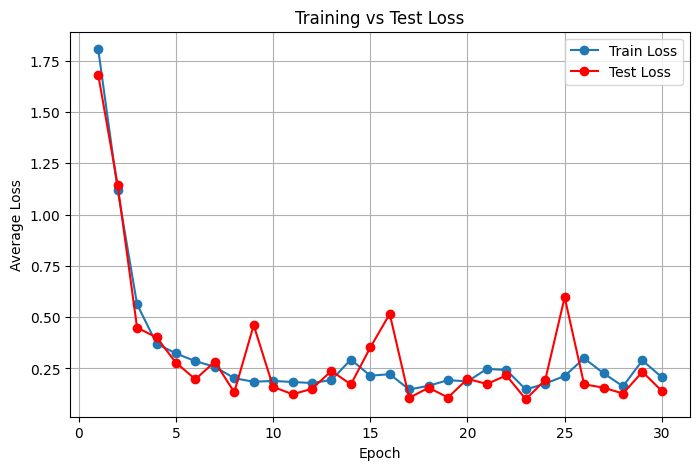

Test Accuracy: 0.8544

Testing params: n_heads=2, num_layers=3, model_dim=32
Epoch [1/30] | Train Loss: 1.7776 | Test Loss: 1.7727
Epoch [2/30] | Train Loss: 1.7510 | Test Loss: 1.5798
Epoch [3/30] | Train Loss: 1.1335 | Test Loss: 0.9004
Epoch [4/30] | Train Loss: 0.7262 | Test Loss: 0.7718
Epoch [5/30] | Train Loss: 0.5209 | Test Loss: 0.3984
Epoch [6/30] | Train Loss: 0.3788 | Test Loss: 0.4770
Epoch [7/30] | Train Loss: 0.3128 | Test Loss: 0.3295
Epoch [8/30] | Train Loss: 0.3287 | Test Loss: 0.2213
Epoch [9/30] | Train Loss: 0.2547 | Test Loss: 0.1952
Epoch [10/30] | Train Loss: 0.2025 | Test Loss: 0.4121
Epoch [11/30] | Train Loss: 0.1784 | Test Loss: 0.2343
Epoch [12/30] | Train Loss: 0.1956 | Test Loss: 0.2456
Epoch [13/30] | Train Loss: 0.2017 | Test Loss: 0.1395
Epoch [14/30] | Train Loss: 0.1601 | Test Loss: 0.2704
Epoch [15/30] | Train Loss: 0.1383 | Test Loss: 0.1364
Epoch [16/30] | Train Loss: 0.1738 | Test Loss: 0.2428
Epoch [17/30] | Train Loss: 0.1308 | Test Loss: 0.13

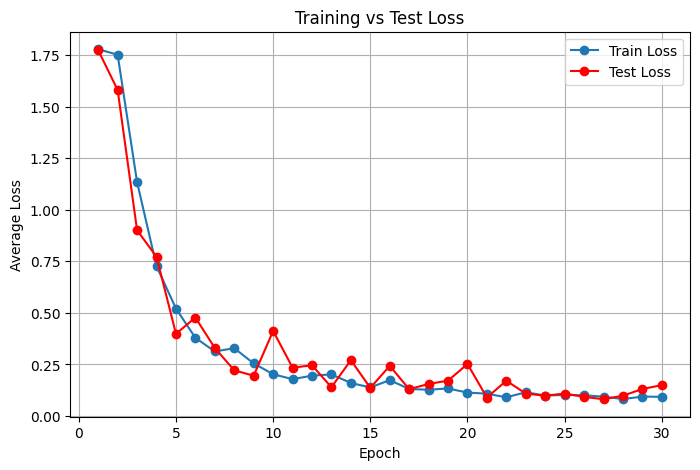

Test Accuracy: 0.9598

Testing params: n_heads=2, num_layers=3, model_dim=64
Epoch [1/30] | Train Loss: 1.7779 | Test Loss: 1.7667
Epoch [2/30] | Train Loss: 1.7721 | Test Loss: 1.7660
Epoch [3/30] | Train Loss: 1.5705 | Test Loss: 0.8887
Epoch [4/30] | Train Loss: 0.6440 | Test Loss: 0.4171
Epoch [5/30] | Train Loss: 0.4229 | Test Loss: 0.6452
Epoch [6/30] | Train Loss: 0.2562 | Test Loss: 0.1869
Epoch [7/30] | Train Loss: 0.1959 | Test Loss: 0.2789
Epoch [8/30] | Train Loss: 0.1708 | Test Loss: 0.2315
Epoch [9/30] | Train Loss: 0.1571 | Test Loss: 0.1338
Epoch [10/30] | Train Loss: 0.1384 | Test Loss: 0.2311
Epoch [11/30] | Train Loss: 0.1291 | Test Loss: 0.1061
Epoch [12/30] | Train Loss: 0.1333 | Test Loss: 0.1610
Epoch [13/30] | Train Loss: 0.1211 | Test Loss: 0.2619
Epoch [14/30] | Train Loss: 0.1421 | Test Loss: 0.1199
Epoch [15/30] | Train Loss: 0.1002 | Test Loss: 0.1079
Epoch [16/30] | Train Loss: 0.0896 | Test Loss: 0.0827
Epoch [17/30] | Train Loss: 0.0984 | Test Loss: 0.08

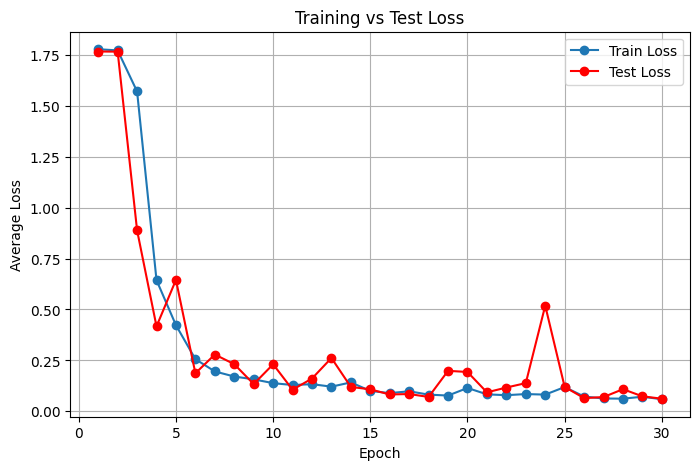

Test Accuracy: 0.9857

Testing params: n_heads=2, num_layers=3, model_dim=128
Epoch [1/30] | Train Loss: 1.7873 | Test Loss: 1.7921
Epoch [2/30] | Train Loss: 1.2937 | Test Loss: 0.7550
Epoch [3/30] | Train Loss: 0.5760 | Test Loss: 0.3239
Epoch [4/30] | Train Loss: 0.3478 | Test Loss: 0.2429
Epoch [5/30] | Train Loss: 0.2613 | Test Loss: 0.2735
Epoch [6/30] | Train Loss: 0.2007 | Test Loss: 0.1880
Epoch [7/30] | Train Loss: 0.2069 | Test Loss: 0.2238
Epoch [8/30] | Train Loss: 0.1965 | Test Loss: 0.2168
Epoch [9/30] | Train Loss: 0.1664 | Test Loss: 0.1260
Epoch [10/30] | Train Loss: 0.1584 | Test Loss: 0.2361
Epoch [11/30] | Train Loss: 0.1445 | Test Loss: 0.1296
Epoch [12/30] | Train Loss: 0.1607 | Test Loss: 0.1561
Epoch [13/30] | Train Loss: 0.1363 | Test Loss: 0.1039
Epoch [14/30] | Train Loss: 0.1400 | Test Loss: 0.1298
Epoch [15/30] | Train Loss: 0.1651 | Test Loss: 0.2426
Epoch [16/30] | Train Loss: 0.1336 | Test Loss: 0.0916
Epoch [17/30] | Train Loss: 0.1567 | Test Loss: 0.1

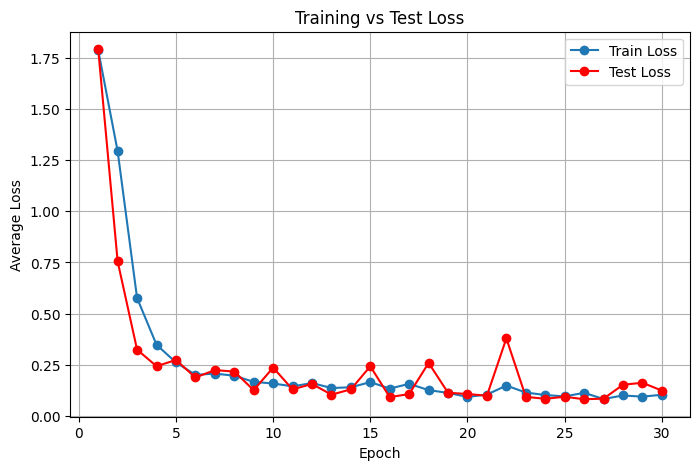

Test Accuracy: 0.9649

Testing params: n_heads=2, num_layers=3, model_dim=256
Epoch [1/30] | Train Loss: 1.7981 | Test Loss: 1.6307
Epoch [2/30] | Train Loss: 1.1536 | Test Loss: 0.9916
Epoch [3/30] | Train Loss: 0.6498 | Test Loss: 0.6130
Epoch [4/30] | Train Loss: 0.4929 | Test Loss: 1.2907
Epoch [5/30] | Train Loss: 0.5349 | Test Loss: 0.6318
Epoch [6/30] | Train Loss: 0.7803 | Test Loss: 0.8348
Epoch [7/30] | Train Loss: 0.4614 | Test Loss: 0.4094
Epoch [8/30] | Train Loss: 0.6296 | Test Loss: 1.8438
Epoch [9/30] | Train Loss: 1.4655 | Test Loss: 1.1761
Epoch [10/30] | Train Loss: 1.7321 | Test Loss: 1.7755
Epoch [11/30] | Train Loss: 1.7784 | Test Loss: 1.7677
Epoch [12/30] | Train Loss: 1.7757 | Test Loss: 1.7718
Epoch [13/30] | Train Loss: 1.7717 | Test Loss: 1.7747
Epoch [14/30] | Train Loss: 1.7714 | Test Loss: 1.7708
Epoch [15/30] | Train Loss: 1.7726 | Test Loss: 1.7709
Epoch [16/30] | Train Loss: 1.7700 | Test Loss: 1.7653
Epoch [17/30] | Train Loss: 1.7670 | Test Loss: 1.7

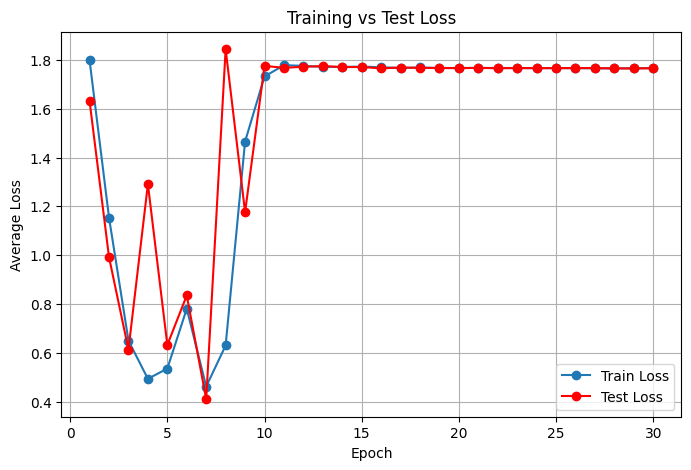

Test Accuracy: 0.2159

Testing params: n_heads=2, num_layers=4, model_dim=32
Epoch [1/30] | Train Loss: 1.7737 | Test Loss: 1.7666
Epoch [2/30] | Train Loss: 1.7681 | Test Loss: 1.7667
Epoch [3/30] | Train Loss: 1.7681 | Test Loss: 1.7693
Epoch [4/30] | Train Loss: 1.7683 | Test Loss: 1.7672
Epoch [5/30] | Train Loss: 1.7589 | Test Loss: 1.6958
Epoch [6/30] | Train Loss: 1.4120 | Test Loss: 0.9126
Epoch [7/30] | Train Loss: 0.7333 | Test Loss: 0.5934
Epoch [8/30] | Train Loss: 0.4839 | Test Loss: 0.4422
Epoch [9/30] | Train Loss: 0.3811 | Test Loss: 0.3164
Epoch [10/30] | Train Loss: 0.2989 | Test Loss: 0.4098
Epoch [11/30] | Train Loss: 0.2857 | Test Loss: 0.2220
Epoch [12/30] | Train Loss: 0.2491 | Test Loss: 0.2612
Epoch [13/30] | Train Loss: 0.2076 | Test Loss: 0.2220
Epoch [14/30] | Train Loss: 0.1864 | Test Loss: 0.2243
Epoch [15/30] | Train Loss: 0.1610 | Test Loss: 0.1600
Epoch [16/30] | Train Loss: 0.1450 | Test Loss: 0.1245
Epoch [17/30] | Train Loss: 0.1387 | Test Loss: 0.11

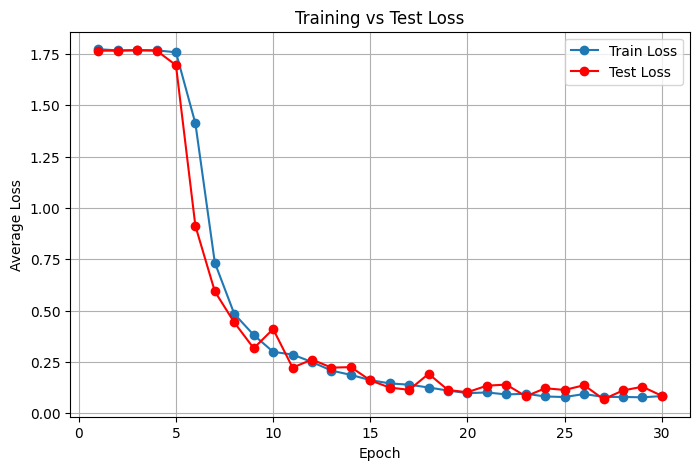

Test Accuracy: 0.9755

Testing params: n_heads=2, num_layers=4, model_dim=64
Epoch [1/30] | Train Loss: 1.7785 | Test Loss: 1.7715
Epoch [2/30] | Train Loss: 1.7723 | Test Loss: 1.7697
Epoch [3/30] | Train Loss: 1.4237 | Test Loss: 1.0689
Epoch [4/30] | Train Loss: 0.9487 | Test Loss: 0.9379
Epoch [5/30] | Train Loss: 0.7596 | Test Loss: 0.9011
Epoch [6/30] | Train Loss: 0.5474 | Test Loss: 0.3909
Epoch [7/30] | Train Loss: 0.3593 | Test Loss: 0.3077
Epoch [8/30] | Train Loss: 0.2867 | Test Loss: 0.3128
Epoch [9/30] | Train Loss: 0.2512 | Test Loss: 0.3089
Epoch [10/30] | Train Loss: 0.1812 | Test Loss: 0.1595
Epoch [11/30] | Train Loss: 0.1554 | Test Loss: 0.1576
Epoch [12/30] | Train Loss: 0.1603 | Test Loss: 0.1338
Epoch [13/30] | Train Loss: 0.1365 | Test Loss: 0.1769
Epoch [14/30] | Train Loss: 0.1365 | Test Loss: 0.1346
Epoch [15/30] | Train Loss: 0.1258 | Test Loss: 0.1924
Epoch [16/30] | Train Loss: 0.1210 | Test Loss: 0.1632
Epoch [17/30] | Train Loss: 0.1137 | Test Loss: 0.15

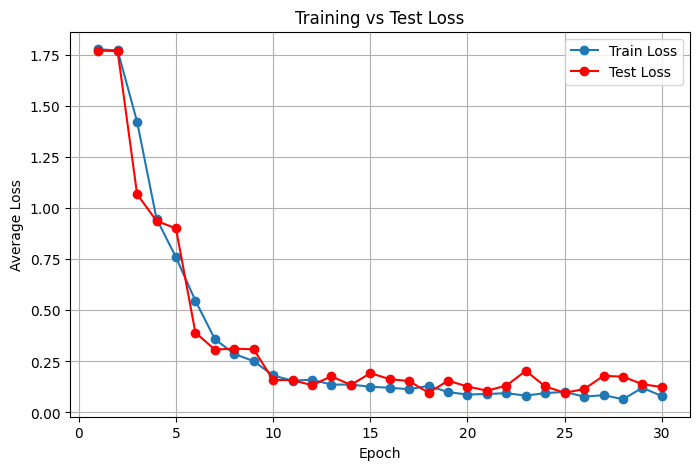

Test Accuracy: 0.9652

Testing params: n_heads=2, num_layers=4, model_dim=128
Epoch [1/30] | Train Loss: 1.7860 | Test Loss: 1.7675
Epoch [2/30] | Train Loss: 1.1978 | Test Loss: 0.9146
Epoch [3/30] | Train Loss: 0.6206 | Test Loss: 0.6053
Epoch [4/30] | Train Loss: 0.4507 | Test Loss: 0.2419
Epoch [5/30] | Train Loss: 0.2995 | Test Loss: 0.3919
Epoch [6/30] | Train Loss: 0.2732 | Test Loss: 0.1554
Epoch [7/30] | Train Loss: 0.2049 | Test Loss: 0.2745
Epoch [8/30] | Train Loss: 0.1822 | Test Loss: 0.1291
Epoch [9/30] | Train Loss: 0.1829 | Test Loss: 0.1657
Epoch [10/30] | Train Loss: 0.1627 | Test Loss: 0.4380
Epoch [11/30] | Train Loss: 0.1746 | Test Loss: 0.1821
Epoch [12/30] | Train Loss: 0.1230 | Test Loss: 0.1327
Epoch [13/30] | Train Loss: 0.1116 | Test Loss: 0.0947
Epoch [14/30] | Train Loss: 0.1348 | Test Loss: 0.1021
Epoch [15/30] | Train Loss: 0.1495 | Test Loss: 0.2448
Epoch [16/30] | Train Loss: 0.1336 | Test Loss: 0.1047
Epoch [17/30] | Train Loss: 0.1335 | Test Loss: 0.1

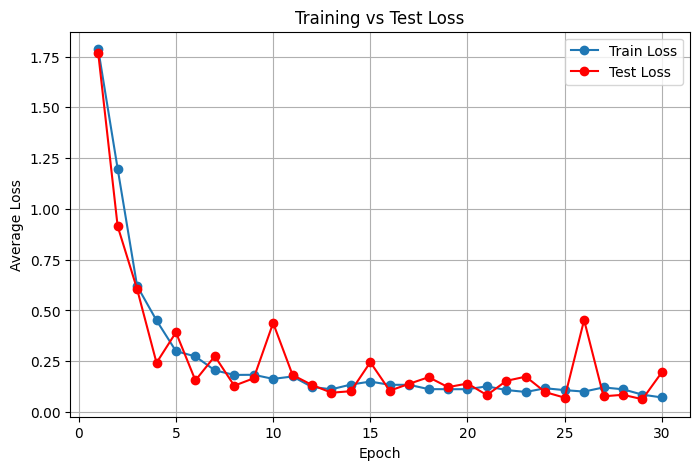

Test Accuracy: 0.9396

Testing params: n_heads=2, num_layers=4, model_dim=256
Epoch [1/30] | Train Loss: 1.7978 | Test Loss: 1.7891
Epoch [2/30] | Train Loss: 1.7822 | Test Loss: 1.7777
Epoch [3/30] | Train Loss: 1.7819 | Test Loss: 1.7679
Epoch [4/30] | Train Loss: 1.7774 | Test Loss: 1.7817
Epoch [5/30] | Train Loss: 1.7746 | Test Loss: 1.7751
Epoch [6/30] | Train Loss: 1.7743 | Test Loss: 1.7740
Epoch [7/30] | Train Loss: 1.7735 | Test Loss: 1.7728
Epoch [8/30] | Train Loss: 1.7743 | Test Loss: 1.7751
Epoch [9/30] | Train Loss: 1.7699 | Test Loss: 1.7688
Epoch [10/30] | Train Loss: 1.7694 | Test Loss: 1.7670
Epoch [11/30] | Train Loss: 1.7677 | Test Loss: 1.7682
Epoch [12/30] | Train Loss: 1.7703 | Test Loss: 1.7660
Epoch [13/30] | Train Loss: 1.7693 | Test Loss: 1.7676
Epoch [14/30] | Train Loss: 1.7670 | Test Loss: 1.7662
Epoch [15/30] | Train Loss: 1.7677 | Test Loss: 1.7673
Epoch [16/30] | Train Loss: 1.7668 | Test Loss: 1.7662
Epoch [17/30] | Train Loss: 1.7668 | Test Loss: 1.7

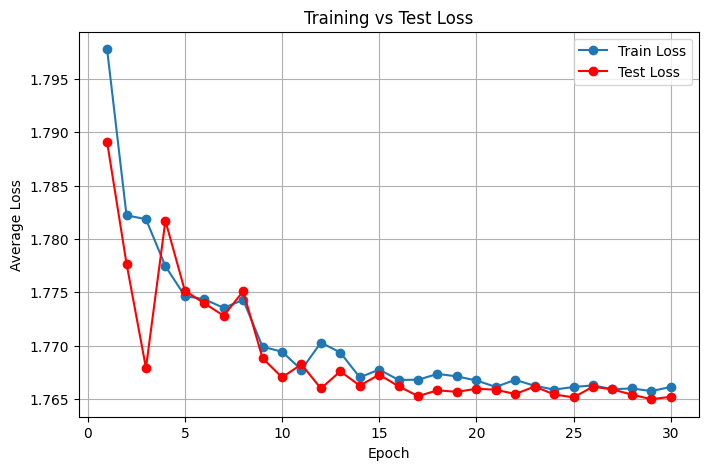

Test Accuracy: 0.2159

Testing params: n_heads=4, num_layers=1, model_dim=32
Epoch [1/30] | Train Loss: 1.7733 | Test Loss: 1.7684
Epoch [2/30] | Train Loss: 1.5906 | Test Loss: 1.1836
Epoch [3/30] | Train Loss: 0.8994 | Test Loss: 1.1389
Epoch [4/30] | Train Loss: 0.6554 | Test Loss: 0.7143
Epoch [5/30] | Train Loss: 0.4888 | Test Loss: 0.4464
Epoch [6/30] | Train Loss: 0.4021 | Test Loss: 0.3792
Epoch [7/30] | Train Loss: 0.3736 | Test Loss: 0.3873
Epoch [8/30] | Train Loss: 0.3419 | Test Loss: 0.3084
Epoch [9/30] | Train Loss: 0.2792 | Test Loss: 0.3504
Epoch [10/30] | Train Loss: 0.2560 | Test Loss: 0.2782
Epoch [11/30] | Train Loss: 0.2292 | Test Loss: 0.2201
Epoch [12/30] | Train Loss: 0.2157 | Test Loss: 0.1808
Epoch [13/30] | Train Loss: 0.1795 | Test Loss: 0.3098
Epoch [14/30] | Train Loss: 0.1912 | Test Loss: 0.1710
Epoch [15/30] | Train Loss: 0.1802 | Test Loss: 0.1921
Epoch [16/30] | Train Loss: 0.1456 | Test Loss: 0.2326
Epoch [17/30] | Train Loss: 0.1651 | Test Loss: 0.12

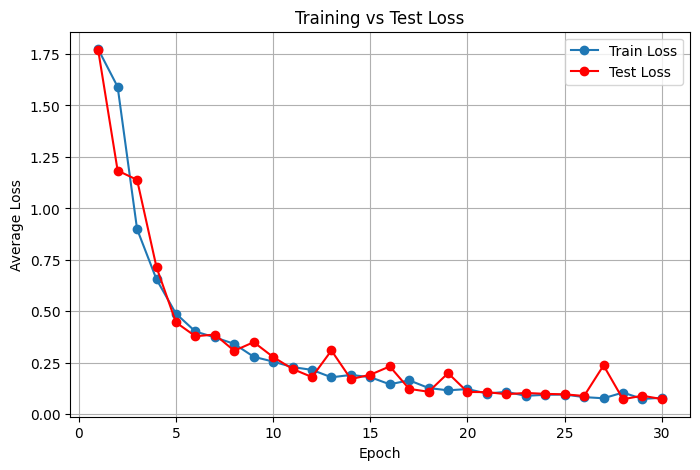

Test Accuracy: 0.9810

Testing params: n_heads=4, num_layers=1, model_dim=64
Epoch [1/30] | Train Loss: 1.7783 | Test Loss: 1.7460
Epoch [2/30] | Train Loss: 1.2571 | Test Loss: 0.8471
Epoch [3/30] | Train Loss: 0.6191 | Test Loss: 0.7541
Epoch [4/30] | Train Loss: 0.4527 | Test Loss: 0.3946
Epoch [5/30] | Train Loss: 0.3720 | Test Loss: 0.4549
Epoch [6/30] | Train Loss: 0.3304 | Test Loss: 0.2699
Epoch [7/30] | Train Loss: 0.2853 | Test Loss: 0.2635
Epoch [8/30] | Train Loss: 0.2380 | Test Loss: 0.3298
Epoch [9/30] | Train Loss: 0.2192 | Test Loss: 0.1804
Epoch [10/30] | Train Loss: 0.2037 | Test Loss: 0.6095
Epoch [11/30] | Train Loss: 0.1969 | Test Loss: 0.1399
Epoch [12/30] | Train Loss: 0.1539 | Test Loss: 0.1854
Epoch [13/30] | Train Loss: 0.1584 | Test Loss: 0.2616
Epoch [14/30] | Train Loss: 0.1410 | Test Loss: 0.2386
Epoch [15/30] | Train Loss: 0.1312 | Test Loss: 0.1180
Epoch [16/30] | Train Loss: 0.1273 | Test Loss: 0.1185
Epoch [17/30] | Train Loss: 0.1206 | Test Loss: 0.16

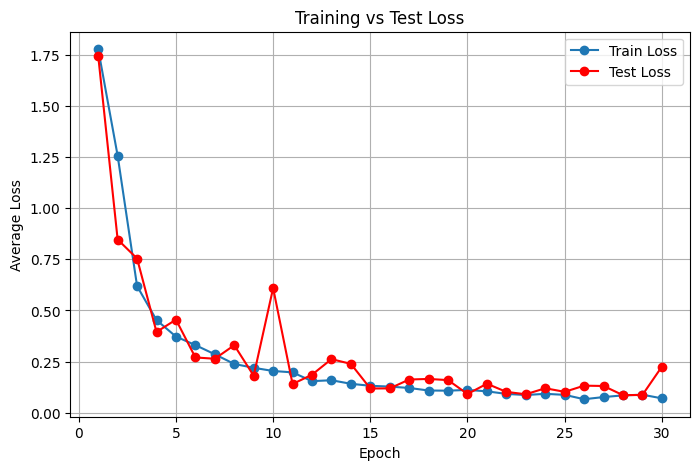

Test Accuracy: 0.9210

Testing params: n_heads=4, num_layers=1, model_dim=128
Epoch [1/30] | Train Loss: 1.4092 | Test Loss: 1.3486
Epoch [2/30] | Train Loss: 0.5473 | Test Loss: 0.8689
Epoch [3/30] | Train Loss: 0.3502 | Test Loss: 0.2319
Epoch [4/30] | Train Loss: 0.2373 | Test Loss: 0.1845
Epoch [5/30] | Train Loss: 0.2599 | Test Loss: 0.2353
Epoch [6/30] | Train Loss: 0.1849 | Test Loss: 0.1318
Epoch [7/30] | Train Loss: 0.1767 | Test Loss: 0.1456
Epoch [8/30] | Train Loss: 0.1629 | Test Loss: 0.1694
Epoch [9/30] | Train Loss: 0.1822 | Test Loss: 0.2446
Epoch [10/30] | Train Loss: 0.1551 | Test Loss: 0.1182
Epoch [11/30] | Train Loss: 0.1508 | Test Loss: 0.2950
Epoch [12/30] | Train Loss: 0.1341 | Test Loss: 0.1299
Epoch [13/30] | Train Loss: 0.1348 | Test Loss: 0.2493
Epoch [14/30] | Train Loss: 0.1423 | Test Loss: 0.1164
Epoch [15/30] | Train Loss: 0.1033 | Test Loss: 0.0902
Epoch [16/30] | Train Loss: 0.1026 | Test Loss: 0.2100
Epoch [17/30] | Train Loss: 0.1144 | Test Loss: 0.0

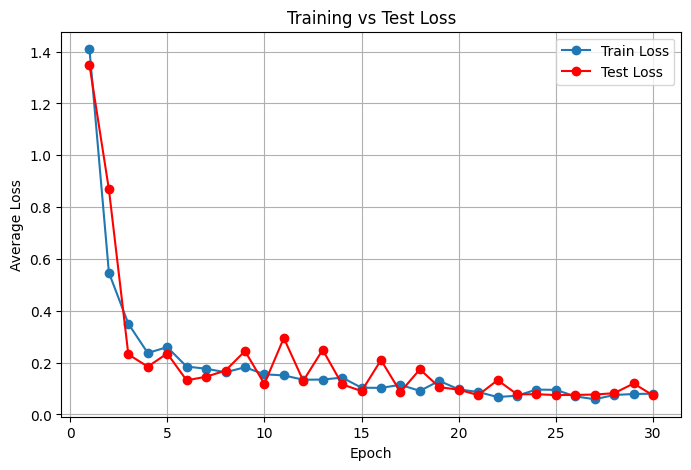

Test Accuracy: 0.9795

Testing params: n_heads=4, num_layers=1, model_dim=256
Epoch [1/30] | Train Loss: 1.3442 | Test Loss: 0.8278
Epoch [2/30] | Train Loss: 0.4784 | Test Loss: 0.4478
Epoch [3/30] | Train Loss: 0.3119 | Test Loss: 0.4846
Epoch [4/30] | Train Loss: 0.2594 | Test Loss: 0.2460
Epoch [5/30] | Train Loss: 0.2351 | Test Loss: 0.3492
Epoch [6/30] | Train Loss: 0.2145 | Test Loss: 0.2281
Epoch [7/30] | Train Loss: 0.1787 | Test Loss: 0.1631
Epoch [8/30] | Train Loss: 0.1668 | Test Loss: 0.2370
Epoch [9/30] | Train Loss: 0.1574 | Test Loss: 0.1500
Epoch [10/30] | Train Loss: 0.1539 | Test Loss: 0.1408
Epoch [11/30] | Train Loss: 0.1205 | Test Loss: 0.7923
Epoch [12/30] | Train Loss: 0.1849 | Test Loss: 0.1352
Epoch [13/30] | Train Loss: 0.1137 | Test Loss: 0.1338
Epoch [14/30] | Train Loss: 0.1184 | Test Loss: 0.1217
Epoch [15/30] | Train Loss: 0.1017 | Test Loss: 0.1263
Epoch [16/30] | Train Loss: 0.1015 | Test Loss: 0.1485
Epoch [17/30] | Train Loss: 0.1067 | Test Loss: 0.1

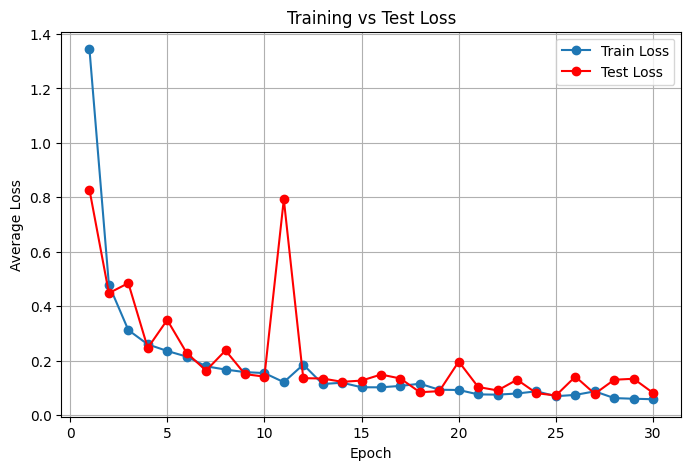

Test Accuracy: 0.9737

Testing params: n_heads=4, num_layers=2, model_dim=32
Epoch [1/30] | Train Loss: 1.7735 | Test Loss: 1.7696
Epoch [2/30] | Train Loss: 1.7522 | Test Loss: 1.5939
Epoch [3/30] | Train Loss: 1.0735 | Test Loss: 0.8341
Epoch [4/30] | Train Loss: 0.6591 | Test Loss: 0.4916
Epoch [5/30] | Train Loss: 0.4365 | Test Loss: 0.3681
Epoch [6/30] | Train Loss: 0.3547 | Test Loss: 0.3227
Epoch [7/30] | Train Loss: 0.3345 | Test Loss: 0.3307
Epoch [8/30] | Train Loss: 0.3070 | Test Loss: 0.2532
Epoch [9/30] | Train Loss: 0.2640 | Test Loss: 0.2715
Epoch [10/30] | Train Loss: 0.2246 | Test Loss: 0.2838
Epoch [11/30] | Train Loss: 0.2265 | Test Loss: 0.2560
Epoch [12/30] | Train Loss: 0.1769 | Test Loss: 0.1451
Epoch [13/30] | Train Loss: 0.1745 | Test Loss: 0.1531
Epoch [14/30] | Train Loss: 0.1459 | Test Loss: 0.1225
Epoch [15/30] | Train Loss: 0.1288 | Test Loss: 0.1338
Epoch [16/30] | Train Loss: 0.1230 | Test Loss: 0.2147
Epoch [17/30] | Train Loss: 0.1151 | Test Loss: 0.16

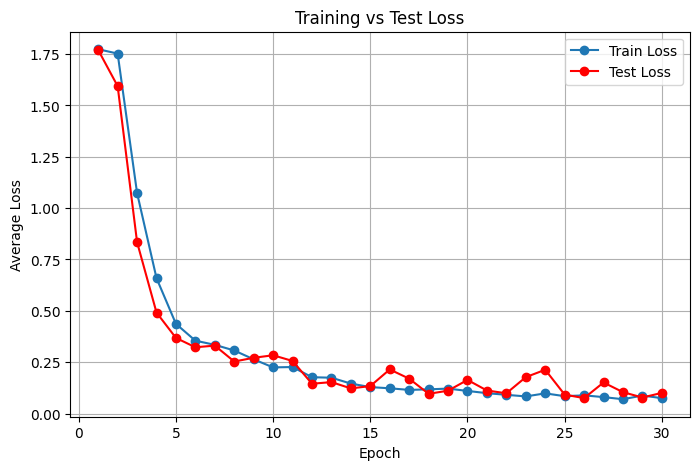

Test Accuracy: 0.9656

Testing params: n_heads=4, num_layers=2, model_dim=64
Epoch [1/30] | Train Loss: 1.6686 | Test Loss: 1.2238
Epoch [2/30] | Train Loss: 0.6694 | Test Loss: 0.4989
Epoch [3/30] | Train Loss: 0.3831 | Test Loss: 0.2565
Epoch [4/30] | Train Loss: 0.2782 | Test Loss: 0.2342
Epoch [5/30] | Train Loss: 0.2267 | Test Loss: 0.4855
Epoch [6/30] | Train Loss: 0.2123 | Test Loss: 0.1635
Epoch [7/30] | Train Loss: 0.1761 | Test Loss: 0.1635
Epoch [8/30] | Train Loss: 0.1491 | Test Loss: 0.1586
Epoch [9/30] | Train Loss: 0.1445 | Test Loss: 0.1168
Epoch [10/30] | Train Loss: 0.1276 | Test Loss: 0.1638
Epoch [11/30] | Train Loss: 0.1278 | Test Loss: 0.1251
Epoch [12/30] | Train Loss: 0.1242 | Test Loss: 0.2000
Epoch [13/30] | Train Loss: 0.1186 | Test Loss: 0.1690
Epoch [14/30] | Train Loss: 0.1122 | Test Loss: 0.1243
Epoch [15/30] | Train Loss: 0.0972 | Test Loss: 0.1010
Epoch [16/30] | Train Loss: 0.0961 | Test Loss: 0.1349
Epoch [17/30] | Train Loss: 0.0906 | Test Loss: 0.14

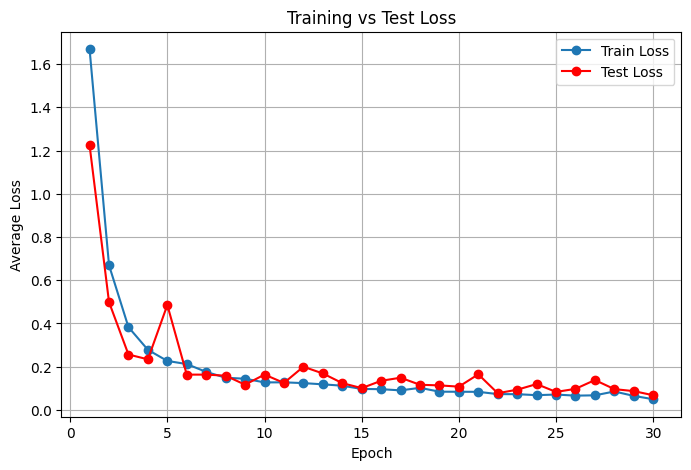

Test Accuracy: 0.9843

Testing params: n_heads=4, num_layers=2, model_dim=128
Epoch [1/30] | Train Loss: 1.7553 | Test Loss: 1.3778
Epoch [2/30] | Train Loss: 0.7449 | Test Loss: 0.8289
Epoch [3/30] | Train Loss: 0.3891 | Test Loss: 0.2619
Epoch [4/30] | Train Loss: 0.3092 | Test Loss: 0.3522
Epoch [5/30] | Train Loss: 0.2220 | Test Loss: 0.1835
Epoch [6/30] | Train Loss: 0.2189 | Test Loss: 0.1754
Epoch [7/30] | Train Loss: 0.1728 | Test Loss: 0.2018
Epoch [8/30] | Train Loss: 0.1529 | Test Loss: 0.1464
Epoch [9/30] | Train Loss: 0.1319 | Test Loss: 0.1175
Epoch [10/30] | Train Loss: 0.1304 | Test Loss: 0.1082
Epoch [11/30] | Train Loss: 0.1190 | Test Loss: 0.1304
Epoch [12/30] | Train Loss: 0.1165 | Test Loss: 0.2266
Epoch [13/30] | Train Loss: 0.1194 | Test Loss: 0.0805
Epoch [14/30] | Train Loss: 0.1045 | Test Loss: 0.0863
Epoch [15/30] | Train Loss: 0.0916 | Test Loss: 0.3510
Epoch [16/30] | Train Loss: 0.0927 | Test Loss: 0.0781
Epoch [17/30] | Train Loss: 0.0926 | Test Loss: 0.0

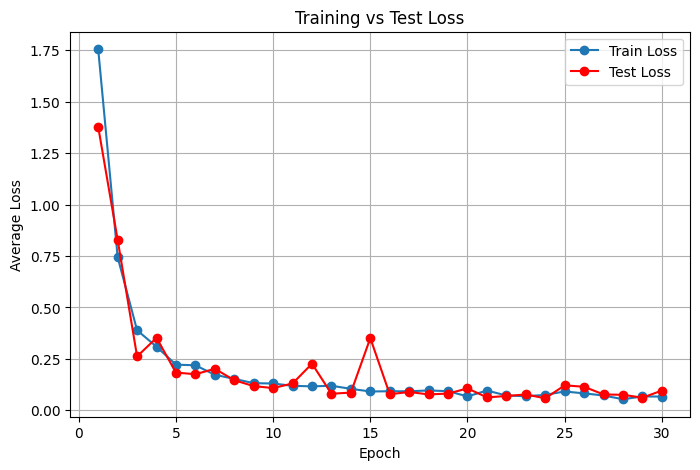

Test Accuracy: 0.9762

Testing params: n_heads=4, num_layers=2, model_dim=256
Epoch [1/30] | Train Loss: 1.3379 | Test Loss: 0.7877
Epoch [2/30] | Train Loss: 0.4857 | Test Loss: 0.3275
Epoch [3/30] | Train Loss: 0.2473 | Test Loss: 0.1876
Epoch [4/30] | Train Loss: 0.2424 | Test Loss: 0.1966
Epoch [5/30] | Train Loss: 0.1905 | Test Loss: 0.2218
Epoch [6/30] | Train Loss: 0.1835 | Test Loss: 0.1532
Epoch [7/30] | Train Loss: 0.1637 | Test Loss: 0.1524
Epoch [8/30] | Train Loss: 0.1759 | Test Loss: 0.1278
Epoch [9/30] | Train Loss: 0.1985 | Test Loss: 0.3951
Epoch [10/30] | Train Loss: 0.1903 | Test Loss: 0.5845
Epoch [11/30] | Train Loss: 0.1804 | Test Loss: 0.1256
Epoch [12/30] | Train Loss: 0.1227 | Test Loss: 0.1119
Epoch [13/30] | Train Loss: 0.1448 | Test Loss: 0.1890
Epoch [14/30] | Train Loss: 0.1995 | Test Loss: 0.1181
Epoch [15/30] | Train Loss: 0.1229 | Test Loss: 0.1572
Epoch [16/30] | Train Loss: 0.1259 | Test Loss: 0.0805
Epoch [17/30] | Train Loss: 0.1179 | Test Loss: 0.4

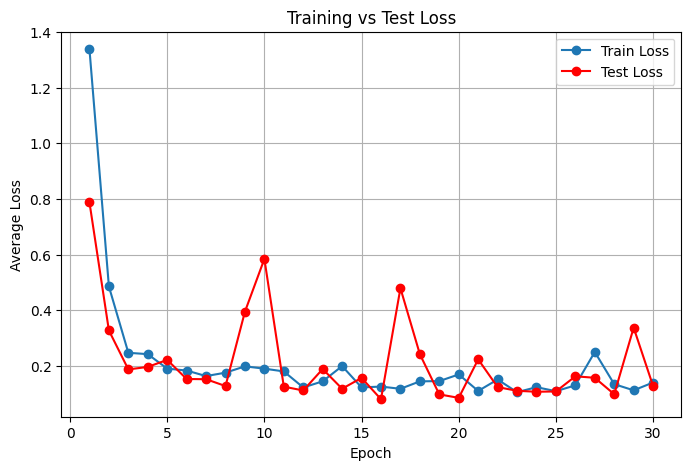

Test Accuracy: 0.9678

Testing params: n_heads=4, num_layers=3, model_dim=32
Epoch [1/30] | Train Loss: 1.7755 | Test Loss: 1.7719
Epoch [2/30] | Train Loss: 1.7694 | Test Loss: 1.7703
Epoch [3/30] | Train Loss: 1.7683 | Test Loss: 1.7670
Epoch [4/30] | Train Loss: 1.7669 | Test Loss: 1.7652
Epoch [5/30] | Train Loss: 1.4346 | Test Loss: 0.9474
Epoch [6/30] | Train Loss: 0.6820 | Test Loss: 0.4583
Epoch [7/30] | Train Loss: 0.4755 | Test Loss: 0.3886
Epoch [8/30] | Train Loss: 0.3851 | Test Loss: 0.3868
Epoch [9/30] | Train Loss: 0.3246 | Test Loss: 0.2878
Epoch [10/30] | Train Loss: 0.2728 | Test Loss: 0.2821
Epoch [11/30] | Train Loss: 0.2443 | Test Loss: 0.2490
Epoch [12/30] | Train Loss: 0.2535 | Test Loss: 0.2129
Epoch [13/30] | Train Loss: 0.2175 | Test Loss: 0.2345
Epoch [14/30] | Train Loss: 0.1636 | Test Loss: 0.2002
Epoch [15/30] | Train Loss: 0.1635 | Test Loss: 0.1426
Epoch [16/30] | Train Loss: 0.1522 | Test Loss: 0.1480
Epoch [17/30] | Train Loss: 0.1426 | Test Loss: 0.14

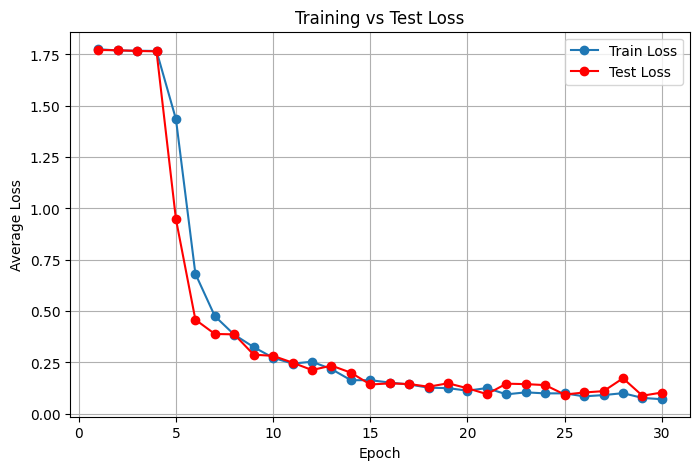

Test Accuracy: 0.9704

Testing params: n_heads=4, num_layers=3, model_dim=64
Epoch [1/30] | Train Loss: 1.7803 | Test Loss: 1.7714
Epoch [2/30] | Train Loss: 1.4529 | Test Loss: 0.7269
Epoch [3/30] | Train Loss: 0.6128 | Test Loss: 0.4488
Epoch [4/30] | Train Loss: 0.3714 | Test Loss: 0.3100
Epoch [5/30] | Train Loss: 0.2975 | Test Loss: 0.3576
Epoch [6/30] | Train Loss: 0.2440 | Test Loss: 0.1591
Epoch [7/30] | Train Loss: 0.1819 | Test Loss: 0.1671
Epoch [8/30] | Train Loss: 0.1643 | Test Loss: 0.1978
Epoch [9/30] | Train Loss: 0.1526 | Test Loss: 0.1672
Epoch [10/30] | Train Loss: 0.1239 | Test Loss: 0.1530
Epoch [11/30] | Train Loss: 0.1183 | Test Loss: 0.1533
Epoch [12/30] | Train Loss: 0.1196 | Test Loss: 0.2838
Epoch [13/30] | Train Loss: 0.1103 | Test Loss: 0.1324
Epoch [14/30] | Train Loss: 0.1073 | Test Loss: 0.1020
Epoch [15/30] | Train Loss: 0.0957 | Test Loss: 0.0888
Epoch [16/30] | Train Loss: 0.1179 | Test Loss: 0.1037
Epoch [17/30] | Train Loss: 0.0909 | Test Loss: 0.10

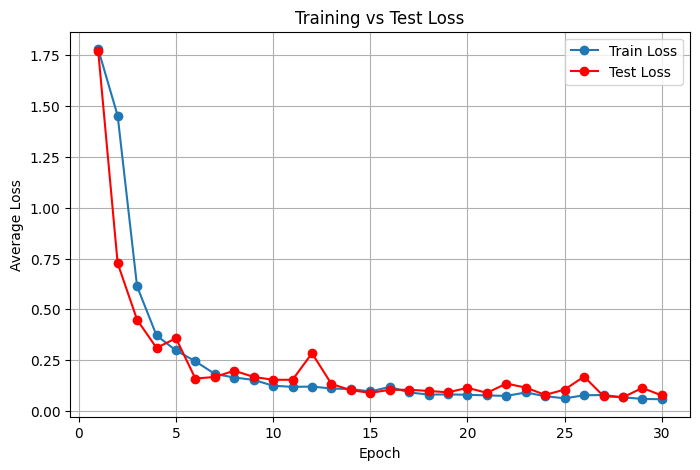

Test Accuracy: 0.9748

Testing params: n_heads=4, num_layers=3, model_dim=128
Epoch [1/30] | Train Loss: 1.7135 | Test Loss: 1.2755
Epoch [2/30] | Train Loss: 1.0540 | Test Loss: 0.6758
Epoch [3/30] | Train Loss: 0.5096 | Test Loss: 0.4158
Epoch [4/30] | Train Loss: 0.3804 | Test Loss: 0.2851
Epoch [5/30] | Train Loss: 0.2434 | Test Loss: 0.4904
Epoch [6/30] | Train Loss: 0.2272 | Test Loss: 0.2023
Epoch [7/30] | Train Loss: 0.1663 | Test Loss: 0.2098
Epoch [8/30] | Train Loss: 0.1788 | Test Loss: 0.3182
Epoch [9/30] | Train Loss: 0.1564 | Test Loss: 0.1916
Epoch [10/30] | Train Loss: 0.1459 | Test Loss: 0.1262
Epoch [11/30] | Train Loss: 0.1184 | Test Loss: 0.2198
Epoch [12/30] | Train Loss: 0.1421 | Test Loss: 0.1681
Epoch [13/30] | Train Loss: 0.1177 | Test Loss: 0.1300
Epoch [14/30] | Train Loss: 0.1038 | Test Loss: 0.1676
Epoch [15/30] | Train Loss: 0.1085 | Test Loss: 0.1466
Epoch [16/30] | Train Loss: 0.1185 | Test Loss: 0.1167
Epoch [17/30] | Train Loss: 0.1084 | Test Loss: 0.1

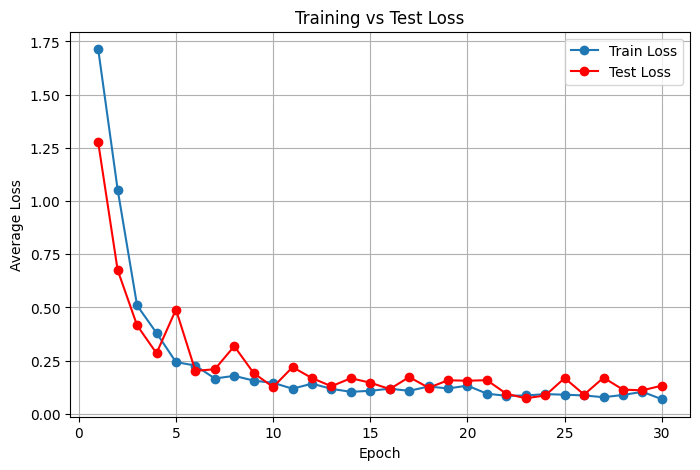

Test Accuracy: 0.9737

Testing params: n_heads=4, num_layers=3, model_dim=256
Epoch [1/30] | Train Loss: 1.8021 | Test Loss: 1.7803
Epoch [2/30] | Train Loss: 1.7817 | Test Loss: 1.7725
Epoch [3/30] | Train Loss: 1.6875 | Test Loss: 1.2762
Epoch [4/30] | Train Loss: 1.3262 | Test Loss: 1.2652
Epoch [5/30] | Train Loss: 1.0663 | Test Loss: 1.0312
Epoch [6/30] | Train Loss: 0.9857 | Test Loss: 1.4391
Epoch [7/30] | Train Loss: 1.4201 | Test Loss: 1.3073
Epoch [8/30] | Train Loss: 1.4512 | Test Loss: 1.9036
Epoch [9/30] | Train Loss: 1.3284 | Test Loss: 1.0103
Epoch [10/30] | Train Loss: 0.9910 | Test Loss: 0.9307
Epoch [11/30] | Train Loss: 0.9365 | Test Loss: 0.8448
Epoch [12/30] | Train Loss: 0.9338 | Test Loss: 0.7670
Epoch [13/30] | Train Loss: 1.1752 | Test Loss: 0.8143
Epoch [14/30] | Train Loss: 1.2991 | Test Loss: 1.5975
Epoch [15/30] | Train Loss: 1.6410 | Test Loss: 1.6861
Epoch [16/30] | Train Loss: 1.7029 | Test Loss: 1.7110
Epoch [17/30] | Train Loss: 1.7240 | Test Loss: 1.7

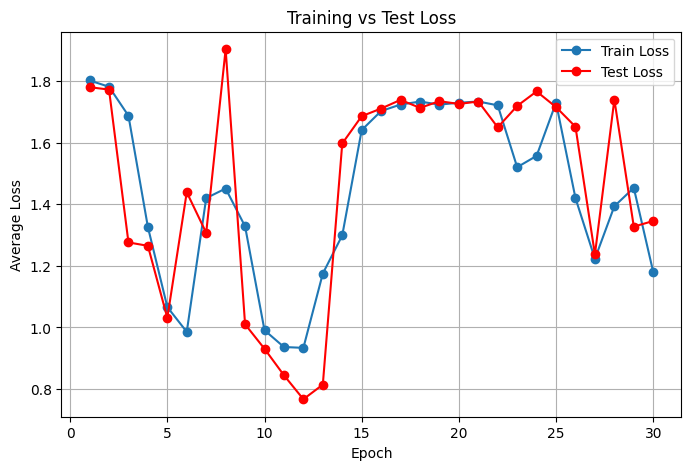

Test Accuracy: 0.2514

Testing params: n_heads=4, num_layers=4, model_dim=32
Epoch [1/30] | Train Loss: 1.7737 | Test Loss: 1.7679
Epoch [2/30] | Train Loss: 1.7698 | Test Loss: 1.7675
Epoch [3/30] | Train Loss: 1.7688 | Test Loss: 1.7680
Epoch [4/30] | Train Loss: 1.7685 | Test Loss: 1.7670
Epoch [5/30] | Train Loss: 1.3586 | Test Loss: 0.9929
Epoch [6/30] | Train Loss: 0.5839 | Test Loss: 0.7562
Epoch [7/30] | Train Loss: 0.4168 | Test Loss: 0.4371
Epoch [8/30] | Train Loss: 0.3345 | Test Loss: 0.2650
Epoch [9/30] | Train Loss: 0.2884 | Test Loss: 0.2274
Epoch [10/30] | Train Loss: 0.2120 | Test Loss: 0.3262
Epoch [11/30] | Train Loss: 0.2037 | Test Loss: 0.1884
Epoch [12/30] | Train Loss: 0.1823 | Test Loss: 0.2561
Epoch [13/30] | Train Loss: 0.1772 | Test Loss: 0.1281
Epoch [14/30] | Train Loss: 0.1395 | Test Loss: 0.1349
Epoch [15/30] | Train Loss: 0.1450 | Test Loss: 0.1264
Epoch [16/30] | Train Loss: 0.1279 | Test Loss: 0.1779
Epoch [17/30] | Train Loss: 0.1249 | Test Loss: 0.12

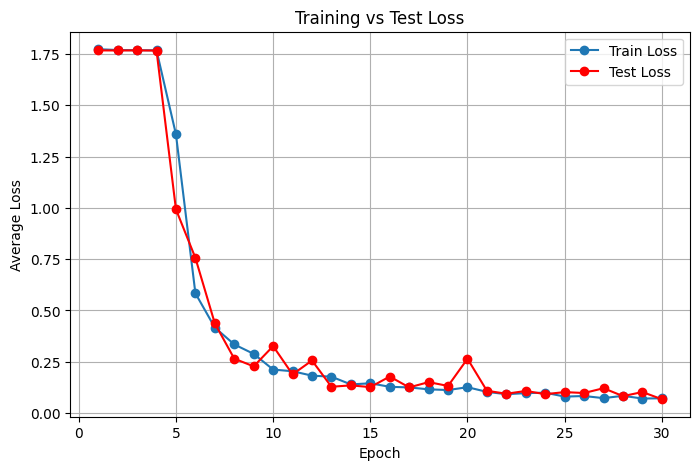

Test Accuracy: 0.9813

Testing params: n_heads=4, num_layers=4, model_dim=64
Epoch [1/30] | Train Loss: 1.7802 | Test Loss: 1.7735
Epoch [2/30] | Train Loss: 1.7724 | Test Loss: 1.7678
Epoch [3/30] | Train Loss: 1.7712 | Test Loss: 1.7745
Epoch [4/30] | Train Loss: 1.5180 | Test Loss: 1.2238
Epoch [5/30] | Train Loss: 0.9711 | Test Loss: 1.0494
Epoch [6/30] | Train Loss: 0.6264 | Test Loss: 0.4601
Epoch [7/30] | Train Loss: 0.3760 | Test Loss: 0.2722
Epoch [8/30] | Train Loss: 0.2702 | Test Loss: 0.2415
Epoch [9/30] | Train Loss: 0.2375 | Test Loss: 0.2657
Epoch [10/30] | Train Loss: 0.2347 | Test Loss: 0.3204
Epoch [11/30] | Train Loss: 0.2175 | Test Loss: 0.3907
Epoch [12/30] | Train Loss: 0.2412 | Test Loss: 0.2271
Epoch [13/30] | Train Loss: 0.1950 | Test Loss: 0.1733
Epoch [14/30] | Train Loss: 0.1682 | Test Loss: 0.1411
Epoch [15/30] | Train Loss: 0.1545 | Test Loss: 0.1611
Epoch [16/30] | Train Loss: 0.1561 | Test Loss: 0.1928
Epoch [17/30] | Train Loss: 0.1700 | Test Loss: 0.37

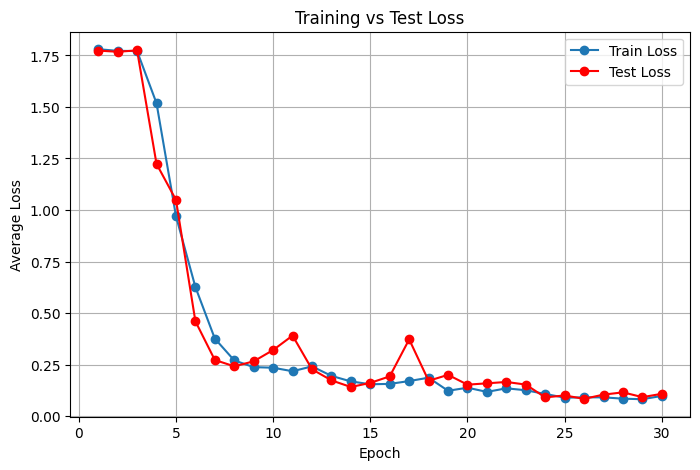

Test Accuracy: 0.9689

Testing params: n_heads=4, num_layers=4, model_dim=128
Epoch [1/30] | Train Loss: 1.7840 | Test Loss: 1.7746
Epoch [2/30] | Train Loss: 1.3882 | Test Loss: 1.1191
Epoch [3/30] | Train Loss: 0.5926 | Test Loss: 0.7314
Epoch [4/30] | Train Loss: 0.3485 | Test Loss: 0.3748
Epoch [5/30] | Train Loss: 0.2609 | Test Loss: 0.2716
Epoch [6/30] | Train Loss: 0.2107 | Test Loss: 0.1851
Epoch [7/30] | Train Loss: 0.1743 | Test Loss: 0.2035
Epoch [8/30] | Train Loss: 0.1676 | Test Loss: 0.1514
Epoch [9/30] | Train Loss: 0.1384 | Test Loss: 0.1516
Epoch [10/30] | Train Loss: 0.1212 | Test Loss: 0.1527
Epoch [11/30] | Train Loss: 0.1233 | Test Loss: 0.1558
Epoch [12/30] | Train Loss: 0.1081 | Test Loss: 0.1108
Epoch [13/30] | Train Loss: 0.1189 | Test Loss: 0.1575
Epoch [14/30] | Train Loss: 0.1172 | Test Loss: 0.1500
Epoch [15/30] | Train Loss: 0.1717 | Test Loss: 0.2337
Epoch [16/30] | Train Loss: 0.1162 | Test Loss: 0.0905
Epoch [17/30] | Train Loss: 0.1094 | Test Loss: 0.0

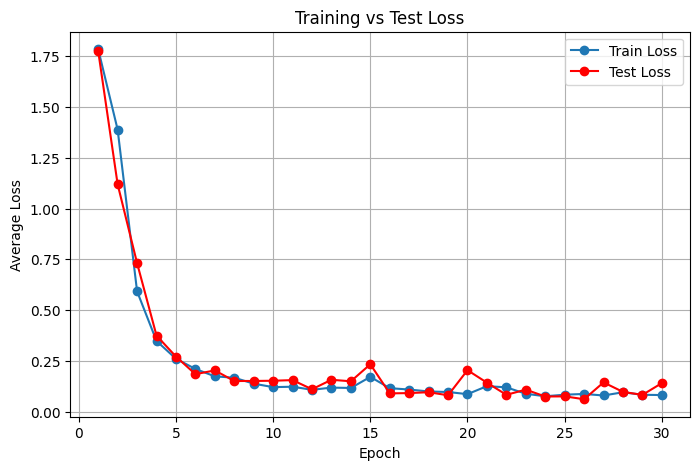

Test Accuracy: 0.9601

Testing params: n_heads=4, num_layers=4, model_dim=256
Epoch [1/30] | Train Loss: 1.8046 | Test Loss: 1.7750
Epoch [2/30] | Train Loss: 1.7653 | Test Loss: 1.7368
Epoch [3/30] | Train Loss: 1.7858 | Test Loss: 1.7686
Epoch [4/30] | Train Loss: 1.7735 | Test Loss: 1.7743
Epoch [5/30] | Train Loss: 1.7734 | Test Loss: 1.7828
Epoch [6/30] | Train Loss: 1.7740 | Test Loss: 1.7711
Epoch [7/30] | Train Loss: 1.7699 | Test Loss: 1.7710
Epoch [8/30] | Train Loss: 1.7708 | Test Loss: 1.7718
Epoch [9/30] | Train Loss: 1.7685 | Test Loss: 1.7694
Epoch [10/30] | Train Loss: 1.7702 | Test Loss: 1.7711
Epoch [11/30] | Train Loss: 1.7688 | Test Loss: 1.7680
Epoch [12/30] | Train Loss: 1.7671 | Test Loss: 1.7664
Epoch [13/30] | Train Loss: 1.7683 | Test Loss: 1.7663
Epoch [14/30] | Train Loss: 1.7661 | Test Loss: 1.7654
Epoch [15/30] | Train Loss: 1.7667 | Test Loss: 1.7658
Epoch [16/30] | Train Loss: 1.7667 | Test Loss: 1.7666
Epoch [17/30] | Train Loss: 1.7671 | Test Loss: 1.7

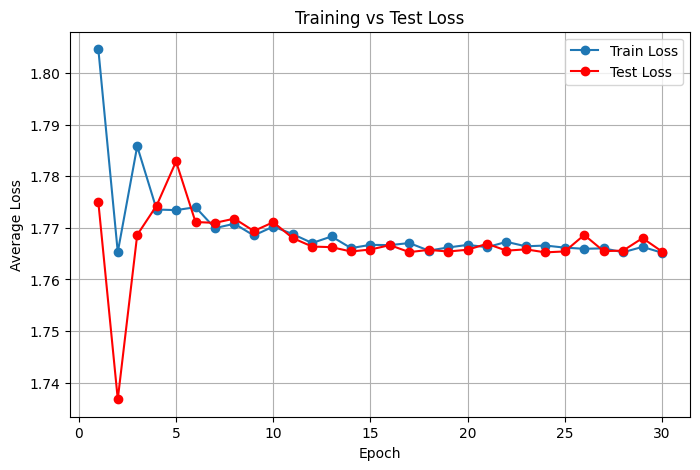

Test Accuracy: 0.2159

Testing params: n_heads=8, num_layers=1, model_dim=32
Epoch [1/30] | Train Loss: 1.7744 | Test Loss: 1.7657
Epoch [2/30] | Train Loss: 1.7701 | Test Loss: 1.7718
Epoch [3/30] | Train Loss: 1.6504 | Test Loss: 1.2431
Epoch [4/30] | Train Loss: 0.7690 | Test Loss: 0.6037
Epoch [5/30] | Train Loss: 0.4197 | Test Loss: 0.3813
Epoch [6/30] | Train Loss: 0.3250 | Test Loss: 0.3312
Epoch [7/30] | Train Loss: 0.2897 | Test Loss: 0.2065
Epoch [8/30] | Train Loss: 0.2200 | Test Loss: 0.2430
Epoch [9/30] | Train Loss: 0.1944 | Test Loss: 0.2838
Epoch [10/30] | Train Loss: 0.1911 | Test Loss: 0.1765
Epoch [11/30] | Train Loss: 0.1852 | Test Loss: 0.1716
Epoch [12/30] | Train Loss: 0.1628 | Test Loss: 0.1537
Epoch [13/30] | Train Loss: 0.1454 | Test Loss: 0.1503
Epoch [14/30] | Train Loss: 0.1471 | Test Loss: 0.1874
Epoch [15/30] | Train Loss: 0.1324 | Test Loss: 0.2296
Epoch [16/30] | Train Loss: 0.1404 | Test Loss: 0.1776
Epoch [17/30] | Train Loss: 0.1322 | Test Loss: 0.12

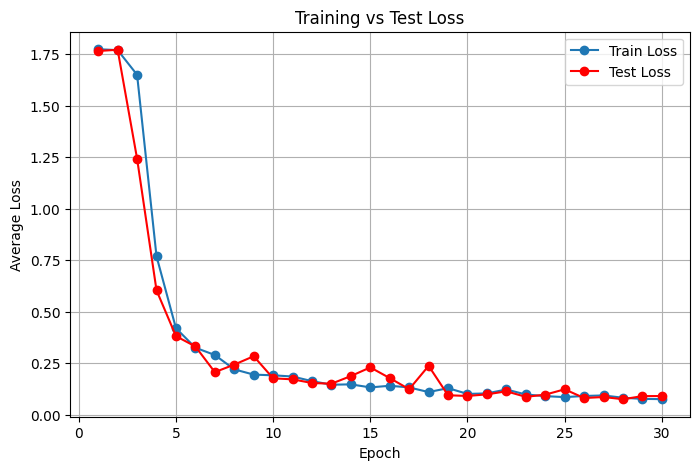

Test Accuracy: 0.9729

Testing params: n_heads=8, num_layers=1, model_dim=64
Epoch [1/30] | Train Loss: 1.7802 | Test Loss: 1.7710
Epoch [2/30] | Train Loss: 1.7001 | Test Loss: 1.5345
Epoch [3/30] | Train Loss: 0.9452 | Test Loss: 0.6363
Epoch [4/30] | Train Loss: 0.5331 | Test Loss: 0.4973
Epoch [5/30] | Train Loss: 0.3641 | Test Loss: 0.3697
Epoch [6/30] | Train Loss: 0.2876 | Test Loss: 0.2648
Epoch [7/30] | Train Loss: 0.2276 | Test Loss: 0.3128
Epoch [8/30] | Train Loss: 0.2558 | Test Loss: 0.1595
Epoch [9/30] | Train Loss: 0.1756 | Test Loss: 0.1568
Epoch [10/30] | Train Loss: 0.1653 | Test Loss: 0.1608
Epoch [11/30] | Train Loss: 0.1643 | Test Loss: 0.1223
Epoch [12/30] | Train Loss: 0.1441 | Test Loss: 0.1673
Epoch [13/30] | Train Loss: 0.1275 | Test Loss: 0.1045
Epoch [14/30] | Train Loss: 0.1248 | Test Loss: 0.1145
Epoch [15/30] | Train Loss: 0.1079 | Test Loss: 0.1413
Epoch [16/30] | Train Loss: 0.1072 | Test Loss: 0.1497
Epoch [17/30] | Train Loss: 0.0956 | Test Loss: 0.07

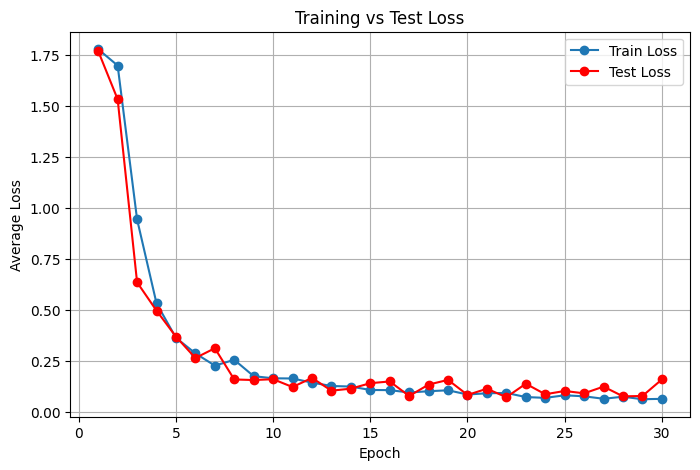

Test Accuracy: 0.9557

Testing params: n_heads=8, num_layers=1, model_dim=128
Epoch [1/30] | Train Loss: 1.6994 | Test Loss: 1.2611
Epoch [2/30] | Train Loss: 0.6473 | Test Loss: 0.4015
Epoch [3/30] | Train Loss: 0.2785 | Test Loss: 0.3477
Epoch [4/30] | Train Loss: 0.2154 | Test Loss: 0.2160
Epoch [5/30] | Train Loss: 0.1810 | Test Loss: 0.1622
Epoch [6/30] | Train Loss: 0.1733 | Test Loss: 0.1225
Epoch [7/30] | Train Loss: 0.1520 | Test Loss: 0.2049
Epoch [8/30] | Train Loss: 0.1218 | Test Loss: 0.1197
Epoch [9/30] | Train Loss: 0.1100 | Test Loss: 0.1006
Epoch [10/30] | Train Loss: 0.1140 | Test Loss: 0.2727
Epoch [11/30] | Train Loss: 0.1264 | Test Loss: 0.1394
Epoch [12/30] | Train Loss: 0.1053 | Test Loss: 0.1641
Epoch [13/30] | Train Loss: 0.1058 | Test Loss: 0.0882
Epoch [14/30] | Train Loss: 0.0823 | Test Loss: 0.0841
Epoch [15/30] | Train Loss: 0.0841 | Test Loss: 0.1293
Epoch [16/30] | Train Loss: 0.0866 | Test Loss: 0.1368
Epoch [17/30] | Train Loss: 0.0903 | Test Loss: 0.2

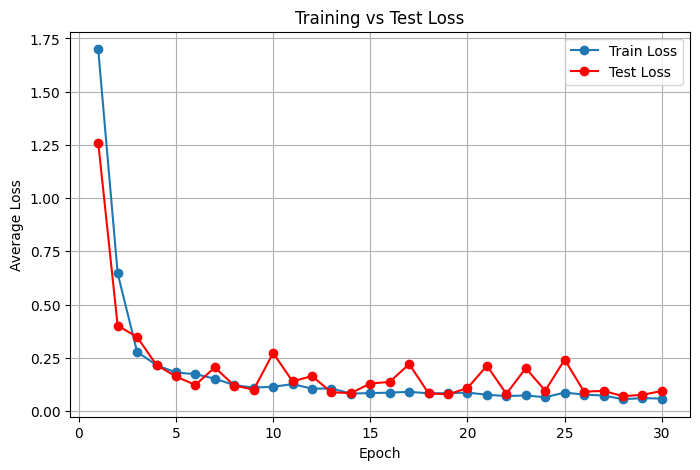

Test Accuracy: 0.9751

Testing params: n_heads=8, num_layers=1, model_dim=256
Epoch [1/30] | Train Loss: 1.2912 | Test Loss: 0.6930
Epoch [2/30] | Train Loss: 0.3910 | Test Loss: 0.3234
Epoch [3/30] | Train Loss: 0.2558 | Test Loss: 0.2431
Epoch [4/30] | Train Loss: 0.1996 | Test Loss: 0.3203
Epoch [5/30] | Train Loss: 0.2000 | Test Loss: 0.3303
Epoch [6/30] | Train Loss: 0.1696 | Test Loss: 0.1200
Epoch [7/30] | Train Loss: 0.1391 | Test Loss: 0.1298
Epoch [8/30] | Train Loss: 0.1223 | Test Loss: 0.1015
Epoch [9/30] | Train Loss: 0.1280 | Test Loss: 0.1402
Epoch [10/30] | Train Loss: 0.1205 | Test Loss: 0.2541
Epoch [11/30] | Train Loss: 0.1248 | Test Loss: 0.1349
Epoch [12/30] | Train Loss: 0.0854 | Test Loss: 0.0849
Epoch [13/30] | Train Loss: 0.0912 | Test Loss: 0.1304
Epoch [14/30] | Train Loss: 0.0892 | Test Loss: 0.0923
Epoch [15/30] | Train Loss: 0.0816 | Test Loss: 0.1182
Epoch [16/30] | Train Loss: 0.0746 | Test Loss: 0.0944
Epoch [17/30] | Train Loss: 0.0849 | Test Loss: 0.1

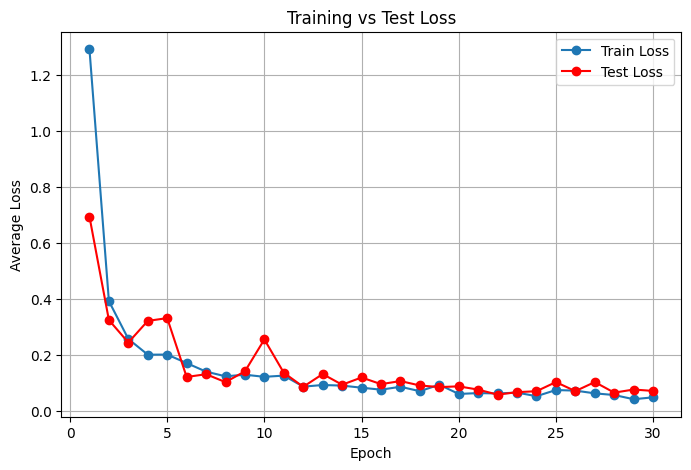

Test Accuracy: 0.9810

Testing params: n_heads=8, num_layers=2, model_dim=32
Epoch [1/30] | Train Loss: 1.7777 | Test Loss: 1.7759
Epoch [2/30] | Train Loss: 1.7710 | Test Loss: 1.7675
Epoch [3/30] | Train Loss: 1.7670 | Test Loss: 1.7591
Epoch [4/30] | Train Loss: 1.3067 | Test Loss: 0.7839
Epoch [5/30] | Train Loss: 0.6184 | Test Loss: 0.5110
Epoch [6/30] | Train Loss: 0.4709 | Test Loss: 0.4150
Epoch [7/30] | Train Loss: 0.3681 | Test Loss: 0.3091
Epoch [8/30] | Train Loss: 0.3226 | Test Loss: 0.3116
Epoch [9/30] | Train Loss: 0.2962 | Test Loss: 0.3957
Epoch [10/30] | Train Loss: 0.2837 | Test Loss: 0.5034
Epoch [11/30] | Train Loss: 0.2563 | Test Loss: 0.2222
Epoch [12/30] | Train Loss: 0.2543 | Test Loss: 0.3296
Epoch [13/30] | Train Loss: 0.2258 | Test Loss: 0.1974
Epoch [14/30] | Train Loss: 0.2167 | Test Loss: 0.2523
Epoch [15/30] | Train Loss: 0.1929 | Test Loss: 0.2551
Epoch [16/30] | Train Loss: 0.1970 | Test Loss: 0.2152
Epoch [17/30] | Train Loss: 0.1832 | Test Loss: 0.21

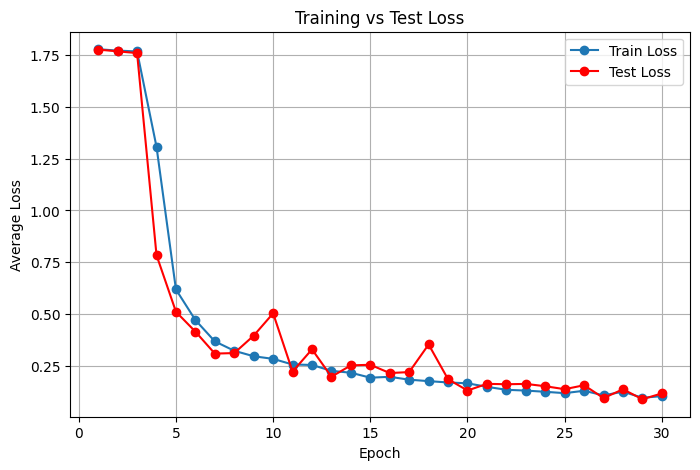

Test Accuracy: 0.9685

Testing params: n_heads=8, num_layers=2, model_dim=64
Epoch [1/30] | Train Loss: 1.7808 | Test Loss: 1.7859
Epoch [2/30] | Train Loss: 1.5103 | Test Loss: 0.8149
Epoch [3/30] | Train Loss: 0.6004 | Test Loss: 0.5235
Epoch [4/30] | Train Loss: 0.4265 | Test Loss: 0.3409
Epoch [5/30] | Train Loss: 0.3045 | Test Loss: 0.3775
Epoch [6/30] | Train Loss: 0.2496 | Test Loss: 0.3866
Epoch [7/30] | Train Loss: 0.2180 | Test Loss: 0.5306
Epoch [8/30] | Train Loss: 0.2213 | Test Loss: 0.1690
Epoch [9/30] | Train Loss: 0.1708 | Test Loss: 0.1768
Epoch [10/30] | Train Loss: 0.1786 | Test Loss: 0.1463
Epoch [11/30] | Train Loss: 0.1455 | Test Loss: 0.1258
Epoch [12/30] | Train Loss: 0.1387 | Test Loss: 0.2279
Epoch [13/30] | Train Loss: 0.1531 | Test Loss: 0.1194
Epoch [14/30] | Train Loss: 0.1171 | Test Loss: 0.1268
Epoch [15/30] | Train Loss: 0.1430 | Test Loss: 0.1432
Epoch [16/30] | Train Loss: 0.1223 | Test Loss: 0.1158
Epoch [17/30] | Train Loss: 0.1154 | Test Loss: 0.14

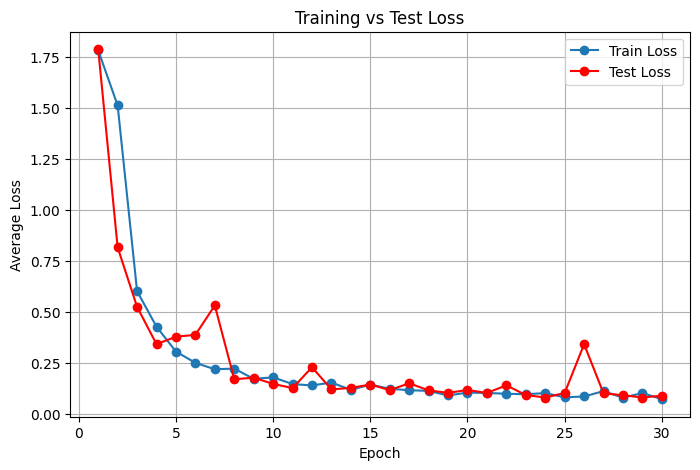

Test Accuracy: 0.9737

Testing params: n_heads=8, num_layers=2, model_dim=128
Epoch [1/30] | Train Loss: 1.7051 | Test Loss: 1.4628
Epoch [2/30] | Train Loss: 0.7210 | Test Loss: 0.9306
Epoch [3/30] | Train Loss: 0.4488 | Test Loss: 0.3717
Epoch [4/30] | Train Loss: 0.3192 | Test Loss: 0.2406
Epoch [5/30] | Train Loss: 0.2596 | Test Loss: 0.2913
Epoch [6/30] | Train Loss: 0.2285 | Test Loss: 0.3794
Epoch [7/30] | Train Loss: 0.1960 | Test Loss: 0.2522
Epoch [8/30] | Train Loss: 0.1589 | Test Loss: 0.1247
Epoch [9/30] | Train Loss: 0.1635 | Test Loss: 0.1335
Epoch [10/30] | Train Loss: 0.1270 | Test Loss: 0.1430
Epoch [11/30] | Train Loss: 0.1313 | Test Loss: 0.0967
Epoch [12/30] | Train Loss: 0.1186 | Test Loss: 0.1104
Epoch [13/30] | Train Loss: 0.1128 | Test Loss: 0.0957
Epoch [14/30] | Train Loss: 0.1183 | Test Loss: 0.2647
Epoch [15/30] | Train Loss: 0.1033 | Test Loss: 0.1116
Epoch [16/30] | Train Loss: 0.0936 | Test Loss: 0.1361
Epoch [17/30] | Train Loss: 0.1325 | Test Loss: 0.1

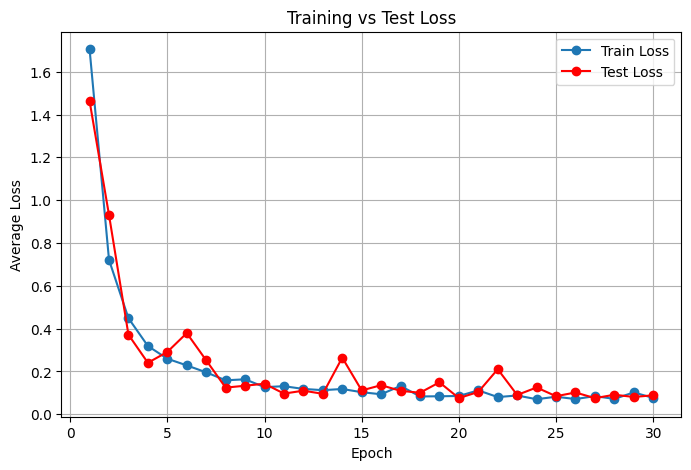

Test Accuracy: 0.9813

Testing params: n_heads=8, num_layers=2, model_dim=256
Epoch [1/30] | Train Loss: 1.6509 | Test Loss: 0.8485
Epoch [2/30] | Train Loss: 0.5718 | Test Loss: 0.3780
Epoch [3/30] | Train Loss: 0.2873 | Test Loss: 0.5146
Epoch [4/30] | Train Loss: 0.2228 | Test Loss: 0.2134
Epoch [5/30] | Train Loss: 0.1785 | Test Loss: 0.2244
Epoch [6/30] | Train Loss: 0.1656 | Test Loss: 0.1579
Epoch [7/30] | Train Loss: 0.1551 | Test Loss: 0.1572
Epoch [8/30] | Train Loss: 0.1526 | Test Loss: 0.1713
Epoch [9/30] | Train Loss: 0.1510 | Test Loss: 0.1217
Epoch [10/30] | Train Loss: 0.1201 | Test Loss: 0.1006
Epoch [11/30] | Train Loss: 0.1188 | Test Loss: 0.1075
Epoch [12/30] | Train Loss: 0.1387 | Test Loss: 0.1225
Epoch [13/30] | Train Loss: 0.1207 | Test Loss: 0.1058
Epoch [14/30] | Train Loss: 0.1034 | Test Loss: 0.0853
Epoch [15/30] | Train Loss: 0.0837 | Test Loss: 0.2076
Epoch [16/30] | Train Loss: 0.1343 | Test Loss: 0.0880
Epoch [17/30] | Train Loss: 0.1153 | Test Loss: 0.1

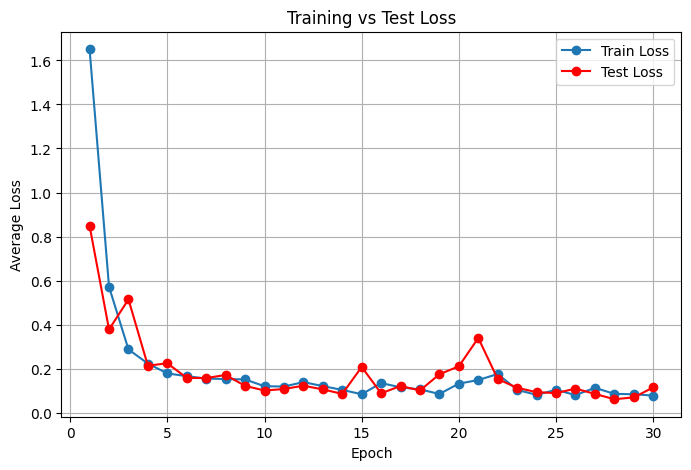

Test Accuracy: 0.9729

Testing params: n_heads=8, num_layers=3, model_dim=32
Epoch [1/30] | Train Loss: 1.7755 | Test Loss: 1.7660
Epoch [2/30] | Train Loss: 1.7701 | Test Loss: 1.7701
Epoch [3/30] | Train Loss: 1.7677 | Test Loss: 1.7656
Epoch [4/30] | Train Loss: 1.7685 | Test Loss: 1.7674
Epoch [5/30] | Train Loss: 1.7605 | Test Loss: 1.7271
Epoch [6/30] | Train Loss: 1.2316 | Test Loss: 0.8106
Epoch [7/30] | Train Loss: 0.6511 | Test Loss: 0.5320
Epoch [8/30] | Train Loss: 0.4782 | Test Loss: 0.6040
Epoch [9/30] | Train Loss: 0.3772 | Test Loss: 0.3684
Epoch [10/30] | Train Loss: 0.3466 | Test Loss: 0.3688
Epoch [11/30] | Train Loss: 0.2947 | Test Loss: 0.3103
Epoch [12/30] | Train Loss: 0.2748 | Test Loss: 0.2617
Epoch [13/30] | Train Loss: 0.2610 | Test Loss: 0.2372
Epoch [14/30] | Train Loss: 0.2311 | Test Loss: 0.2151
Epoch [15/30] | Train Loss: 0.2350 | Test Loss: 0.2519
Epoch [16/30] | Train Loss: 0.2162 | Test Loss: 0.2284
Epoch [17/30] | Train Loss: 0.1813 | Test Loss: 0.17

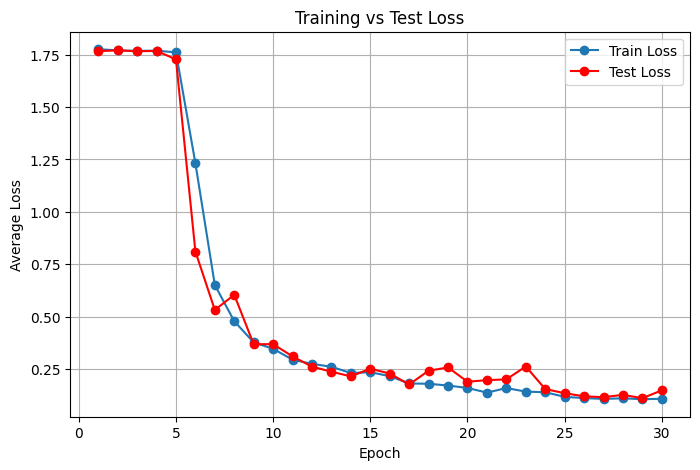

Test Accuracy: 0.9616

Testing params: n_heads=8, num_layers=3, model_dim=64
Epoch [1/30] | Train Loss: 1.7801 | Test Loss: 1.7763
Epoch [2/30] | Train Loss: 1.7736 | Test Loss: 1.7812
Epoch [3/30] | Train Loss: 1.7687 | Test Loss: 1.7665
Epoch [4/30] | Train Loss: 1.2794 | Test Loss: 0.9214
Epoch [5/30] | Train Loss: 0.6932 | Test Loss: 0.5870
Epoch [6/30] | Train Loss: 0.4303 | Test Loss: 0.5130
Epoch [7/30] | Train Loss: 0.3476 | Test Loss: 0.2993
Epoch [8/30] | Train Loss: 0.2433 | Test Loss: 0.1790
Epoch [9/30] | Train Loss: 0.2066 | Test Loss: 0.3074
Epoch [10/30] | Train Loss: 0.1823 | Test Loss: 0.1792
Epoch [11/30] | Train Loss: 0.1682 | Test Loss: 0.1876
Epoch [12/30] | Train Loss: 0.1712 | Test Loss: 0.1709
Epoch [13/30] | Train Loss: 0.1449 | Test Loss: 0.1533
Epoch [14/30] | Train Loss: 0.1441 | Test Loss: 0.1473
Epoch [15/30] | Train Loss: 0.1226 | Test Loss: 0.1231
Epoch [16/30] | Train Loss: 0.1128 | Test Loss: 0.1077
Epoch [17/30] | Train Loss: 0.1145 | Test Loss: 0.15

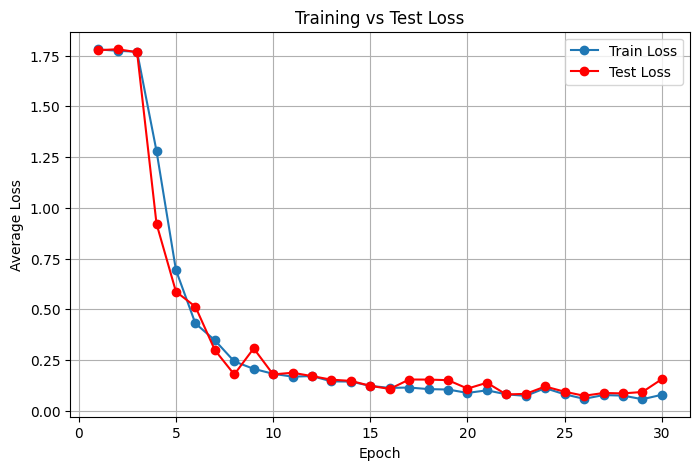

Test Accuracy: 0.9477

Testing params: n_heads=8, num_layers=3, model_dim=128
Epoch [1/30] | Train Loss: 1.7872 | Test Loss: 1.7656
Epoch [2/30] | Train Loss: 1.3574 | Test Loss: 1.0920
Epoch [3/30] | Train Loss: 0.8093 | Test Loss: 1.1473
Epoch [4/30] | Train Loss: 0.4557 | Test Loss: 0.4783
Epoch [5/30] | Train Loss: 0.3504 | Test Loss: 1.4152
Epoch [6/30] | Train Loss: 0.3905 | Test Loss: 0.2191
Epoch [7/30] | Train Loss: 0.2145 | Test Loss: 0.2248
Epoch [8/30] | Train Loss: 0.1871 | Test Loss: 0.1706
Epoch [9/30] | Train Loss: 0.1592 | Test Loss: 0.1882
Epoch [10/30] | Train Loss: 0.1540 | Test Loss: 0.1938
Epoch [11/30] | Train Loss: 0.1339 | Test Loss: 0.0846
Epoch [12/30] | Train Loss: 0.1062 | Test Loss: 0.1349
Epoch [13/30] | Train Loss: 0.1173 | Test Loss: 0.1069
Epoch [14/30] | Train Loss: 0.1030 | Test Loss: 0.1502
Epoch [15/30] | Train Loss: 0.0976 | Test Loss: 0.2343
Epoch [16/30] | Train Loss: 0.1140 | Test Loss: 0.0806
Epoch [17/30] | Train Loss: 0.0821 | Test Loss: 0.0

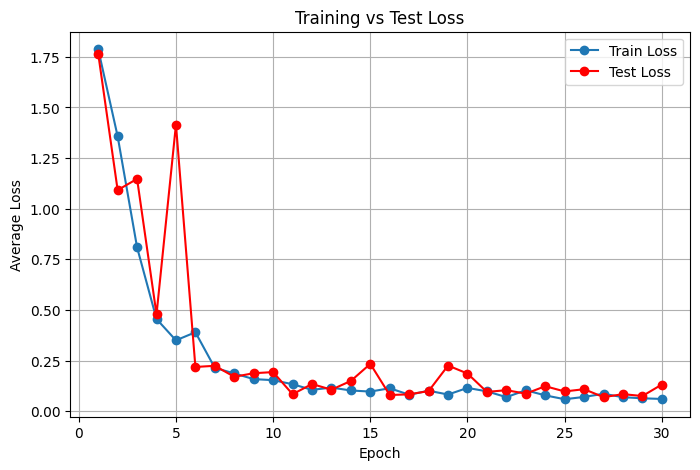

Test Accuracy: 0.9524

Testing params: n_heads=8, num_layers=3, model_dim=256
Epoch [1/30] | Train Loss: 1.8009 | Test Loss: 1.7807
Epoch [2/30] | Train Loss: 1.7753 | Test Loss: 1.6773
Epoch [3/30] | Train Loss: 1.4794 | Test Loss: 1.3251
Epoch [4/30] | Train Loss: 0.9961 | Test Loss: 0.8362
Epoch [5/30] | Train Loss: 0.8418 | Test Loss: 0.9018
Epoch [6/30] | Train Loss: 0.6675 | Test Loss: 0.5593
Epoch [7/30] | Train Loss: 0.5500 | Test Loss: 0.4519
Epoch [8/30] | Train Loss: 0.6840 | Test Loss: 1.0474
Epoch [9/30] | Train Loss: 0.7127 | Test Loss: 1.5429
Epoch [10/30] | Train Loss: 1.2429 | Test Loss: 0.9717
Epoch [11/30] | Train Loss: 0.8729 | Test Loss: 0.8711
Epoch [12/30] | Train Loss: 0.8827 | Test Loss: 1.0071
Epoch [13/30] | Train Loss: 0.6983 | Test Loss: 0.4399
Epoch [14/30] | Train Loss: 0.5403 | Test Loss: 0.4842
Epoch [15/30] | Train Loss: 0.4956 | Test Loss: 0.6803
Epoch [16/30] | Train Loss: 0.6273 | Test Loss: 0.3801
Epoch [17/30] | Train Loss: 0.4330 | Test Loss: 0.3

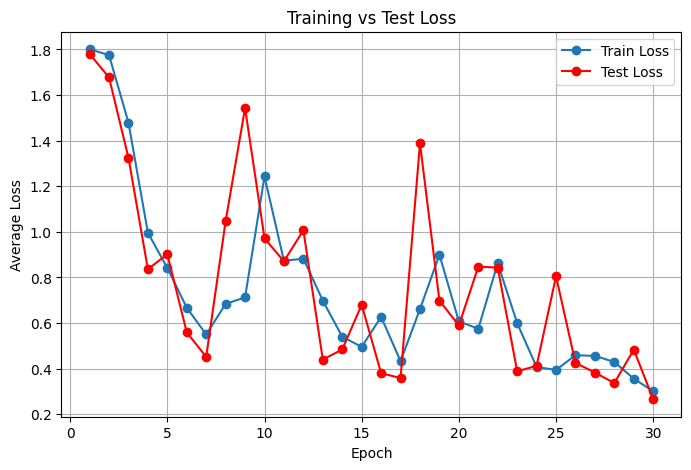

Test Accuracy: 0.6718

Testing params: n_heads=8, num_layers=4, model_dim=32
Epoch [1/30] | Train Loss: 1.7764 | Test Loss: 1.7774
Epoch [2/30] | Train Loss: 1.7679 | Test Loss: 1.7668
Epoch [3/30] | Train Loss: 1.6625 | Test Loss: 1.4338
Epoch [4/30] | Train Loss: 1.0972 | Test Loss: 1.0501
Epoch [5/30] | Train Loss: 0.9578 | Test Loss: 0.8520
Epoch [6/30] | Train Loss: 0.7911 | Test Loss: 0.6552
Epoch [7/30] | Train Loss: 0.5957 | Test Loss: 0.5112
Epoch [8/30] | Train Loss: 0.5036 | Test Loss: 0.4332
Epoch [9/30] | Train Loss: 0.4047 | Test Loss: 0.3301
Epoch [10/30] | Train Loss: 0.3584 | Test Loss: 0.4230
Epoch [11/30] | Train Loss: 0.3020 | Test Loss: 0.3160
Epoch [12/30] | Train Loss: 0.2745 | Test Loss: 0.2165
Epoch [13/30] | Train Loss: 0.2691 | Test Loss: 0.2698
Epoch [14/30] | Train Loss: 0.2412 | Test Loss: 0.2091
Epoch [15/30] | Train Loss: 0.2716 | Test Loss: 0.2603
Epoch [16/30] | Train Loss: 0.2144 | Test Loss: 0.1759
Epoch [17/30] | Train Loss: 0.1869 | Test Loss: 0.39

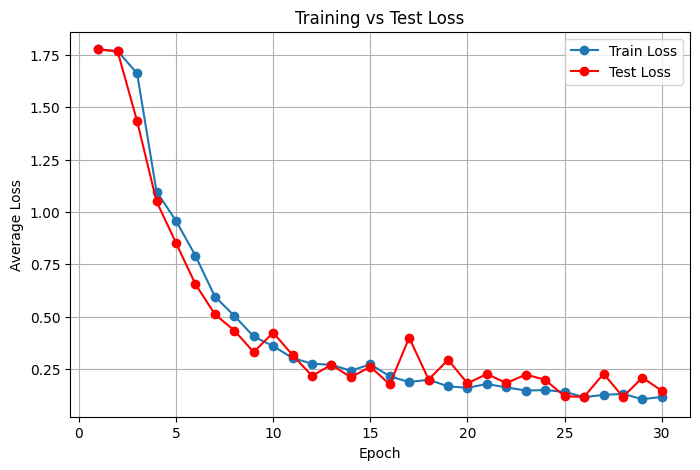

Test Accuracy: 0.9667

Testing params: n_heads=8, num_layers=4, model_dim=64
Epoch [1/30] | Train Loss: 1.7813 | Test Loss: 1.7710
Epoch [2/30] | Train Loss: 1.7220 | Test Loss: 1.5973
Epoch [3/30] | Train Loss: 1.1697 | Test Loss: 1.0228
Epoch [4/30] | Train Loss: 0.9424 | Test Loss: 0.7630
Epoch [5/30] | Train Loss: 0.6656 | Test Loss: 0.5788
Epoch [6/30] | Train Loss: 0.4304 | Test Loss: 0.3143
Epoch [7/30] | Train Loss: 0.3144 | Test Loss: 0.3202
Epoch [8/30] | Train Loss: 0.2530 | Test Loss: 0.4745
Epoch [9/30] | Train Loss: 0.2289 | Test Loss: 0.2424
Epoch [10/30] | Train Loss: 0.1823 | Test Loss: 0.1986
Epoch [11/30] | Train Loss: 0.1613 | Test Loss: 0.2358
Epoch [12/30] | Train Loss: 0.1539 | Test Loss: 0.1412
Epoch [13/30] | Train Loss: 0.1536 | Test Loss: 0.1602
Epoch [14/30] | Train Loss: 0.1205 | Test Loss: 0.1176
Epoch [15/30] | Train Loss: 0.1344 | Test Loss: 0.1214
Epoch [16/30] | Train Loss: 0.1185 | Test Loss: 0.1149
Epoch [17/30] | Train Loss: 0.1155 | Test Loss: 0.14

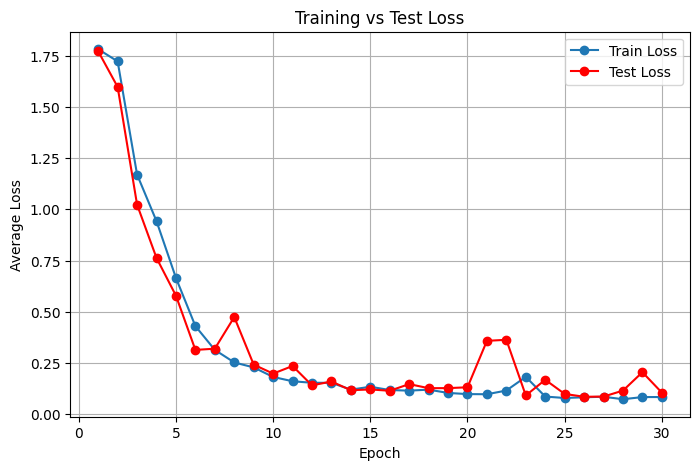

Test Accuracy: 0.9682

Testing params: n_heads=8, num_layers=4, model_dim=128
Epoch [1/30] | Train Loss: 1.7927 | Test Loss: 1.7886
Epoch [2/30] | Train Loss: 1.5664 | Test Loss: 1.0836
Epoch [3/30] | Train Loss: 0.8388 | Test Loss: 0.6236
Epoch [4/30] | Train Loss: 0.4501 | Test Loss: 0.4522
Epoch [5/30] | Train Loss: 0.3023 | Test Loss: 0.4557
Epoch [6/30] | Train Loss: 0.2331 | Test Loss: 0.1598
Epoch [7/30] | Train Loss: 0.1748 | Test Loss: 0.1973
Epoch [8/30] | Train Loss: 0.1846 | Test Loss: 0.1623
Epoch [9/30] | Train Loss: 0.1884 | Test Loss: 0.1582
Epoch [10/30] | Train Loss: 0.1363 | Test Loss: 0.1595
Epoch [11/30] | Train Loss: 0.1366 | Test Loss: 0.1724
Epoch [12/30] | Train Loss: 0.1537 | Test Loss: 0.1191
Epoch [13/30] | Train Loss: 0.1263 | Test Loss: 0.2249
Epoch [14/30] | Train Loss: 0.1154 | Test Loss: 0.1199
Epoch [15/30] | Train Loss: 0.1074 | Test Loss: 0.1212
Epoch [16/30] | Train Loss: 0.1082 | Test Loss: 0.2070
Epoch [17/30] | Train Loss: 0.1111 | Test Loss: 0.1

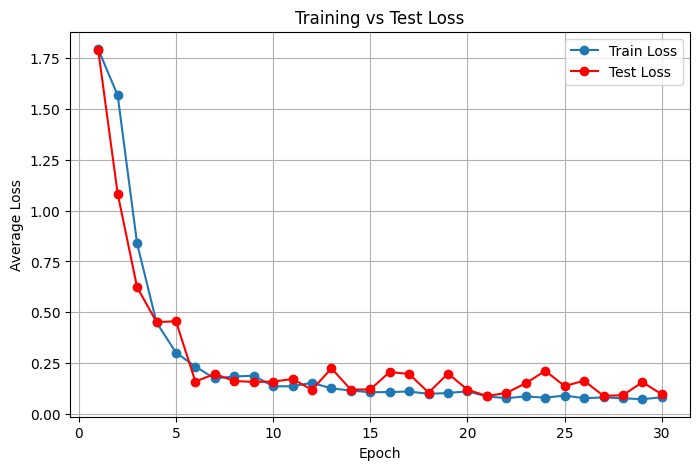

Test Accuracy: 0.9832

Testing params: n_heads=8, num_layers=4, model_dim=256
Epoch [1/30] | Train Loss: 1.8030 | Test Loss: 1.7731
Epoch [2/30] | Train Loss: 1.7783 | Test Loss: 1.7838
Epoch [3/30] | Train Loss: 1.7778 | Test Loss: 1.7692
Epoch [4/30] | Train Loss: 1.7771 | Test Loss: 1.7698
Epoch [5/30] | Train Loss: 1.7727 | Test Loss: 1.7692
Epoch [6/30] | Train Loss: 1.7733 | Test Loss: 1.7737
Epoch [7/30] | Train Loss: 1.7702 | Test Loss: 1.7672
Epoch [8/30] | Train Loss: 1.7704 | Test Loss: 1.7708
Epoch [9/30] | Train Loss: 1.7707 | Test Loss: 1.7665
Epoch [10/30] | Train Loss: 1.7707 | Test Loss: 1.7677
Epoch [11/30] | Train Loss: 1.7678 | Test Loss: 1.7667
Epoch [12/30] | Train Loss: 1.7679 | Test Loss: 1.7704
Epoch [13/30] | Train Loss: 1.7707 | Test Loss: 1.7684
Epoch [14/30] | Train Loss: 1.7674 | Test Loss: 1.7666
Epoch [15/30] | Train Loss: 1.7681 | Test Loss: 1.7671
Epoch [16/30] | Train Loss: 1.7676 | Test Loss: 1.7670
Epoch [17/30] | Train Loss: 1.7664 | Test Loss: 1.7

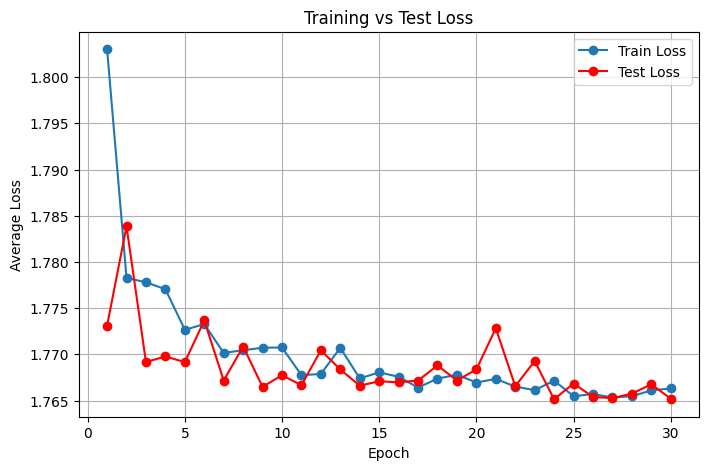

Test Accuracy: 0.2159

Testing params: n_heads=16, num_layers=1, model_dim=32
Epoch [1/30] | Train Loss: 1.7772 | Test Loss: 1.7662
Epoch [2/30] | Train Loss: 1.6741 | Test Loss: 1.2840
Epoch [3/30] | Train Loss: 0.9511 | Test Loss: 0.6674
Epoch [4/30] | Train Loss: 0.5672 | Test Loss: 0.5421
Epoch [5/30] | Train Loss: 0.4098 | Test Loss: 0.3413
Epoch [6/30] | Train Loss: 0.3073 | Test Loss: 0.2609
Epoch [7/30] | Train Loss: 0.2396 | Test Loss: 0.2190
Epoch [8/30] | Train Loss: 0.2322 | Test Loss: 0.2890
Epoch [9/30] | Train Loss: 0.2142 | Test Loss: 0.3306
Epoch [10/30] | Train Loss: 0.1881 | Test Loss: 0.2229
Epoch [11/30] | Train Loss: 0.1918 | Test Loss: 0.1950
Epoch [12/30] | Train Loss: 0.1611 | Test Loss: 0.1444
Epoch [13/30] | Train Loss: 0.1720 | Test Loss: 0.1669
Epoch [14/30] | Train Loss: 0.1453 | Test Loss: 0.1429
Epoch [15/30] | Train Loss: 0.1395 | Test Loss: 0.1592
Epoch [16/30] | Train Loss: 0.1346 | Test Loss: 0.1616
Epoch [17/30] | Train Loss: 0.1226 | Test Loss: 0.1

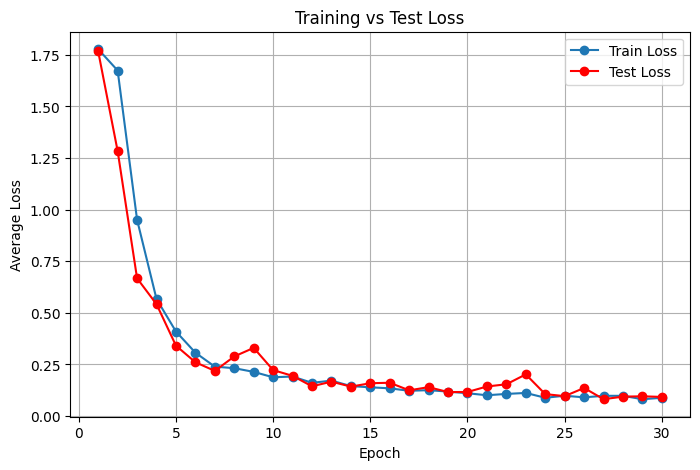

Test Accuracy: 0.9791

Testing params: n_heads=16, num_layers=1, model_dim=64
Epoch [1/30] | Train Loss: 1.7750 | Test Loss: 1.7454
Epoch [2/30] | Train Loss: 1.1376 | Test Loss: 1.0401
Epoch [3/30] | Train Loss: 0.6768 | Test Loss: 0.5082
Epoch [4/30] | Train Loss: 0.3874 | Test Loss: 0.3191
Epoch [5/30] | Train Loss: 0.2870 | Test Loss: 0.2546
Epoch [6/30] | Train Loss: 0.2223 | Test Loss: 0.4690
Epoch [7/30] | Train Loss: 0.2084 | Test Loss: 0.1889
Epoch [8/30] | Train Loss: 0.1749 | Test Loss: 0.3453
Epoch [9/30] | Train Loss: 0.1682 | Test Loss: 0.1773
Epoch [10/30] | Train Loss: 0.1364 | Test Loss: 0.1372
Epoch [11/30] | Train Loss: 0.1226 | Test Loss: 0.1212
Epoch [12/30] | Train Loss: 0.1082 | Test Loss: 0.1202
Epoch [13/30] | Train Loss: 0.1088 | Test Loss: 0.1081
Epoch [14/30] | Train Loss: 0.1138 | Test Loss: 0.1751
Epoch [15/30] | Train Loss: 0.0957 | Test Loss: 0.1106
Epoch [16/30] | Train Loss: 0.0958 | Test Loss: 0.0938
Epoch [17/30] | Train Loss: 0.1070 | Test Loss: 0.0

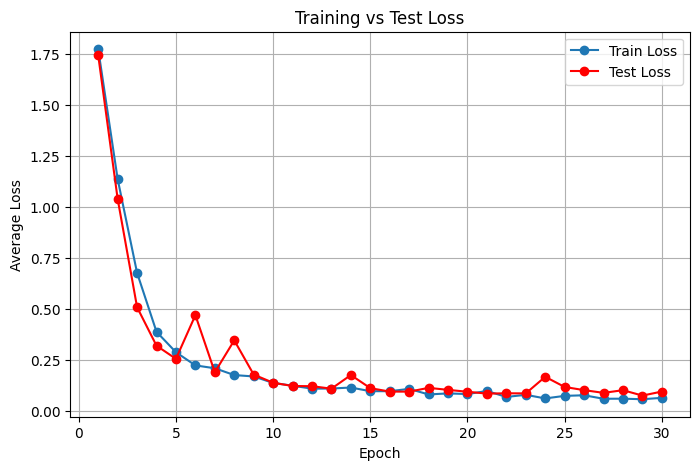

Test Accuracy: 0.9806

Testing params: n_heads=16, num_layers=1, model_dim=128
Epoch [1/30] | Train Loss: 1.6912 | Test Loss: 1.1463
Epoch [2/30] | Train Loss: 0.7624 | Test Loss: 0.6769
Epoch [3/30] | Train Loss: 0.4337 | Test Loss: 0.3151
Epoch [4/30] | Train Loss: 0.2728 | Test Loss: 0.3295
Epoch [5/30] | Train Loss: 0.2141 | Test Loss: 0.1687
Epoch [6/30] | Train Loss: 0.1619 | Test Loss: 0.1441
Epoch [7/30] | Train Loss: 0.1609 | Test Loss: 0.1152
Epoch [8/30] | Train Loss: 0.1200 | Test Loss: 0.1874
Epoch [9/30] | Train Loss: 0.1208 | Test Loss: 0.1024
Epoch [10/30] | Train Loss: 0.0968 | Test Loss: 0.1291
Epoch [11/30] | Train Loss: 0.0981 | Test Loss: 0.2163
Epoch [12/30] | Train Loss: 0.1019 | Test Loss: 0.0784
Epoch [13/30] | Train Loss: 0.0809 | Test Loss: 0.0886
Epoch [14/30] | Train Loss: 0.0763 | Test Loss: 0.0882
Epoch [15/30] | Train Loss: 0.0745 | Test Loss: 0.0856
Epoch [16/30] | Train Loss: 0.0814 | Test Loss: 0.1045
Epoch [17/30] | Train Loss: 0.0707 | Test Loss: 0.

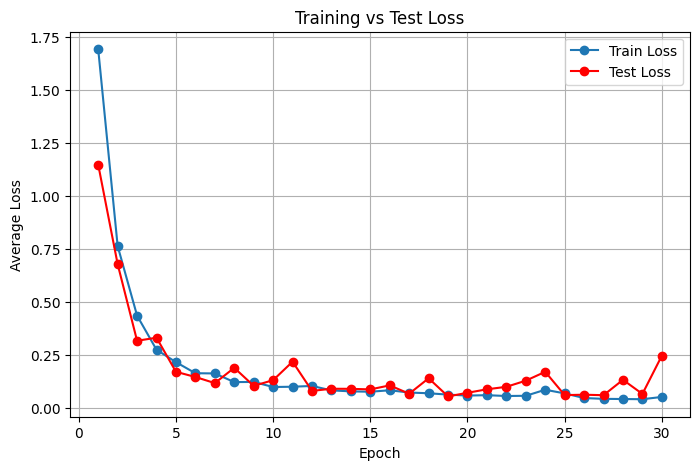

Test Accuracy: 0.9360

Testing params: n_heads=16, num_layers=1, model_dim=256
Epoch [1/30] | Train Loss: 1.4832 | Test Loss: 0.7420
Epoch [2/30] | Train Loss: 0.4317 | Test Loss: 0.3502
Epoch [3/30] | Train Loss: 0.2798 | Test Loss: 0.2186
Epoch [4/30] | Train Loss: 0.2334 | Test Loss: 0.4031
Epoch [5/30] | Train Loss: 0.1603 | Test Loss: 0.1658
Epoch [6/30] | Train Loss: 0.1609 | Test Loss: 0.1235
Epoch [7/30] | Train Loss: 0.1435 | Test Loss: 0.1497
Epoch [8/30] | Train Loss: 0.1319 | Test Loss: 0.1432
Epoch [9/30] | Train Loss: 0.1323 | Test Loss: 0.1315
Epoch [10/30] | Train Loss: 0.1112 | Test Loss: 0.1282
Epoch [11/30] | Train Loss: 0.1357 | Test Loss: 0.0925
Epoch [12/30] | Train Loss: 0.0958 | Test Loss: 0.0866
Epoch [13/30] | Train Loss: 0.0888 | Test Loss: 0.2533
Epoch [14/30] | Train Loss: 0.0845 | Test Loss: 0.1052
Epoch [15/30] | Train Loss: 0.0792 | Test Loss: 0.1053
Epoch [16/30] | Train Loss: 0.0830 | Test Loss: 0.0873
Epoch [17/30] | Train Loss: 0.0706 | Test Loss: 0.

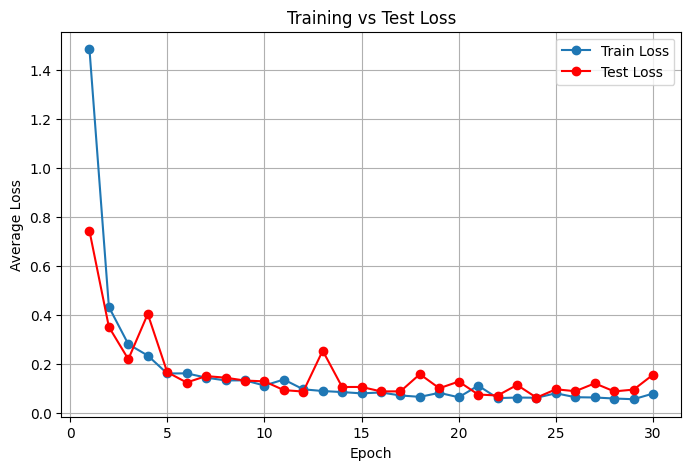

Test Accuracy: 0.9550

Testing params: n_heads=16, num_layers=2, model_dim=32
Epoch [1/30] | Train Loss: 1.7772 | Test Loss: 1.7730
Epoch [2/30] | Train Loss: 1.7694 | Test Loss: 1.7642
Epoch [3/30] | Train Loss: 1.4053 | Test Loss: 1.0546
Epoch [4/30] | Train Loss: 0.8990 | Test Loss: 0.8731
Epoch [5/30] | Train Loss: 0.6801 | Test Loss: 0.4832
Epoch [6/30] | Train Loss: 0.4640 | Test Loss: 0.4887
Epoch [7/30] | Train Loss: 0.3421 | Test Loss: 0.2800
Epoch [8/30] | Train Loss: 0.2955 | Test Loss: 0.3571
Epoch [9/30] | Train Loss: 0.2478 | Test Loss: 0.2387
Epoch [10/30] | Train Loss: 0.2340 | Test Loss: 0.1932
Epoch [11/30] | Train Loss: 0.2163 | Test Loss: 0.2232
Epoch [12/30] | Train Loss: 0.1930 | Test Loss: 0.2026
Epoch [13/30] | Train Loss: 0.1683 | Test Loss: 0.2069
Epoch [14/30] | Train Loss: 0.1788 | Test Loss: 0.1887
Epoch [15/30] | Train Loss: 0.1679 | Test Loss: 0.2269
Epoch [16/30] | Train Loss: 0.1629 | Test Loss: 0.1660
Epoch [17/30] | Train Loss: 0.1467 | Test Loss: 0.1

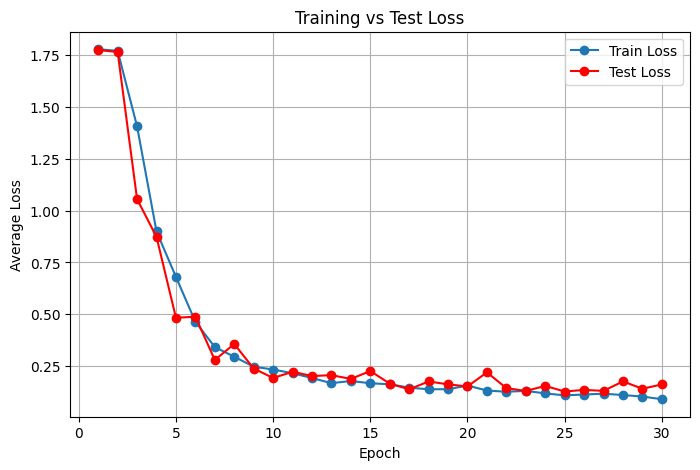

Test Accuracy: 0.9550

Testing params: n_heads=16, num_layers=2, model_dim=64
Epoch [1/30] | Train Loss: 1.7832 | Test Loss: 1.7719
Epoch [2/30] | Train Loss: 1.6565 | Test Loss: 1.2224
Epoch [3/30] | Train Loss: 0.6292 | Test Loss: 0.4103
Epoch [4/30] | Train Loss: 0.3483 | Test Loss: 0.3094
Epoch [5/30] | Train Loss: 0.2526 | Test Loss: 0.2706
Epoch [6/30] | Train Loss: 0.1910 | Test Loss: 0.1995
Epoch [7/30] | Train Loss: 0.1629 | Test Loss: 0.1423
Epoch [8/30] | Train Loss: 0.1587 | Test Loss: 0.1919
Epoch [9/30] | Train Loss: 0.1670 | Test Loss: 0.2973
Epoch [10/30] | Train Loss: 0.1276 | Test Loss: 0.1969
Epoch [11/30] | Train Loss: 0.1181 | Test Loss: 0.1197
Epoch [12/30] | Train Loss: 0.1184 | Test Loss: 0.1239
Epoch [13/30] | Train Loss: 0.1159 | Test Loss: 0.1643
Epoch [14/30] | Train Loss: 0.1030 | Test Loss: 0.1000
Epoch [15/30] | Train Loss: 0.0933 | Test Loss: 0.1146
Epoch [16/30] | Train Loss: 0.0942 | Test Loss: 0.1182
Epoch [17/30] | Train Loss: 0.0851 | Test Loss: 0.0

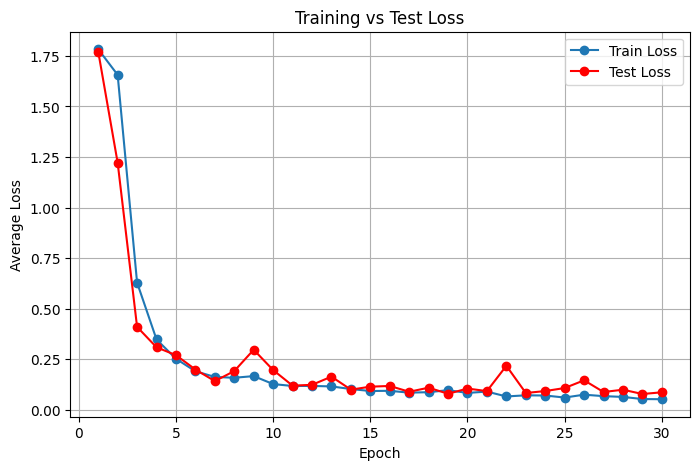

Test Accuracy: 0.9729

Testing params: n_heads=16, num_layers=2, model_dim=128
Epoch [1/30] | Train Loss: 1.7657 | Test Loss: 1.6257
Epoch [2/30] | Train Loss: 0.7286 | Test Loss: 0.6289
Epoch [3/30] | Train Loss: 0.3132 | Test Loss: 0.5086
Epoch [4/30] | Train Loss: 0.2285 | Test Loss: 0.1849
Epoch [5/30] | Train Loss: 0.1759 | Test Loss: 0.1476
Epoch [6/30] | Train Loss: 0.1731 | Test Loss: 0.1469
Epoch [7/30] | Train Loss: 0.1386 | Test Loss: 0.1224
Epoch [8/30] | Train Loss: 0.1426 | Test Loss: 0.1106
Epoch [9/30] | Train Loss: 0.1443 | Test Loss: 0.1627
Epoch [10/30] | Train Loss: 0.1070 | Test Loss: 0.0883
Epoch [11/30] | Train Loss: 0.0983 | Test Loss: 0.2061
Epoch [12/30] | Train Loss: 0.1079 | Test Loss: 0.1194
Epoch [13/30] | Train Loss: 0.0969 | Test Loss: 0.0817
Epoch [14/30] | Train Loss: 0.0891 | Test Loss: 0.1253
Epoch [15/30] | Train Loss: 0.0948 | Test Loss: 0.0777
Epoch [16/30] | Train Loss: 0.0811 | Test Loss: 0.0816
Epoch [17/30] | Train Loss: 0.0799 | Test Loss: 0.

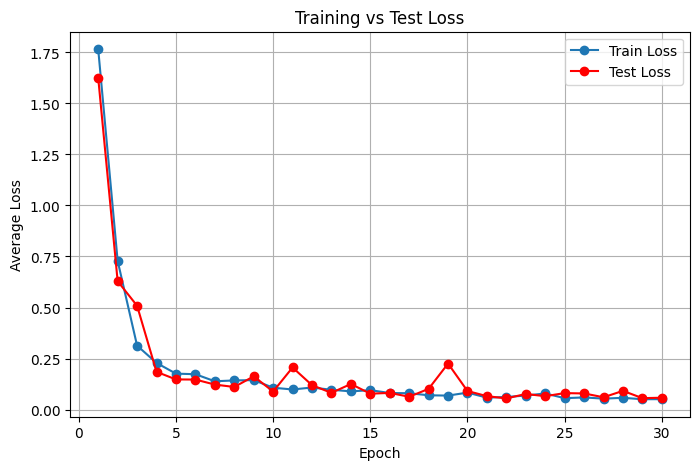

Test Accuracy: 0.9887

Testing params: n_heads=16, num_layers=2, model_dim=256
Epoch [1/30] | Train Loss: 1.7989 | Test Loss: 1.7006
Epoch [2/30] | Train Loss: 0.8494 | Test Loss: 0.7760
Epoch [3/30] | Train Loss: 0.3567 | Test Loss: 0.2843
Epoch [4/30] | Train Loss: 0.2146 | Test Loss: 0.2204
Epoch [5/30] | Train Loss: 0.1719 | Test Loss: 0.2489
Epoch [6/30] | Train Loss: 0.1466 | Test Loss: 0.1562
Epoch [7/30] | Train Loss: 0.1340 | Test Loss: 0.1876
Epoch [8/30] | Train Loss: 0.1367 | Test Loss: 0.1140
Epoch [9/30] | Train Loss: 0.1269 | Test Loss: 0.1495
Epoch [10/30] | Train Loss: 0.0975 | Test Loss: 0.0924
Epoch [11/30] | Train Loss: 0.0957 | Test Loss: 0.1494
Epoch [12/30] | Train Loss: 0.1120 | Test Loss: 0.2072
Epoch [13/30] | Train Loss: 0.1079 | Test Loss: 0.1057
Epoch [14/30] | Train Loss: 0.1124 | Test Loss: 0.1178
Epoch [15/30] | Train Loss: 0.0835 | Test Loss: 0.0798
Epoch [16/30] | Train Loss: 0.0808 | Test Loss: 0.1078
Epoch [17/30] | Train Loss: 0.0770 | Test Loss: 0.

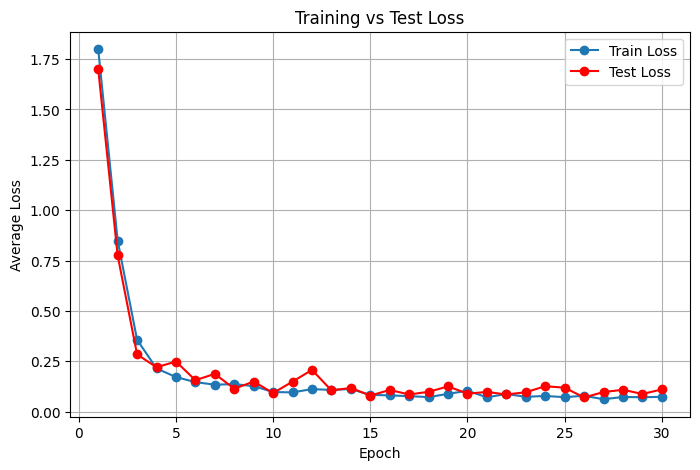

Test Accuracy: 0.9704

Testing params: n_heads=16, num_layers=3, model_dim=32
Epoch [1/30] | Train Loss: 1.7749 | Test Loss: 1.7765
Epoch [2/30] | Train Loss: 1.7690 | Test Loss: 1.7704
Epoch [3/30] | Train Loss: 1.6910 | Test Loss: 1.2737
Epoch [4/30] | Train Loss: 0.9479 | Test Loss: 0.8567
Epoch [5/30] | Train Loss: 0.6232 | Test Loss: 0.5262
Epoch [6/30] | Train Loss: 0.5055 | Test Loss: 0.5059
Epoch [7/30] | Train Loss: 0.4615 | Test Loss: 0.5522
Epoch [8/30] | Train Loss: 0.4128 | Test Loss: 0.4188
Epoch [9/30] | Train Loss: 0.3791 | Test Loss: 0.4161
Epoch [10/30] | Train Loss: 0.3789 | Test Loss: 0.4659
Epoch [11/30] | Train Loss: 0.3398 | Test Loss: 0.3592
Epoch [12/30] | Train Loss: 0.3105 | Test Loss: 0.3195
Epoch [13/30] | Train Loss: 0.2917 | Test Loss: 0.2685
Epoch [14/30] | Train Loss: 0.2703 | Test Loss: 0.2517
Epoch [15/30] | Train Loss: 0.2456 | Test Loss: 0.2587
Epoch [16/30] | Train Loss: 0.2272 | Test Loss: 0.2629
Epoch [17/30] | Train Loss: 0.2389 | Test Loss: 0.3

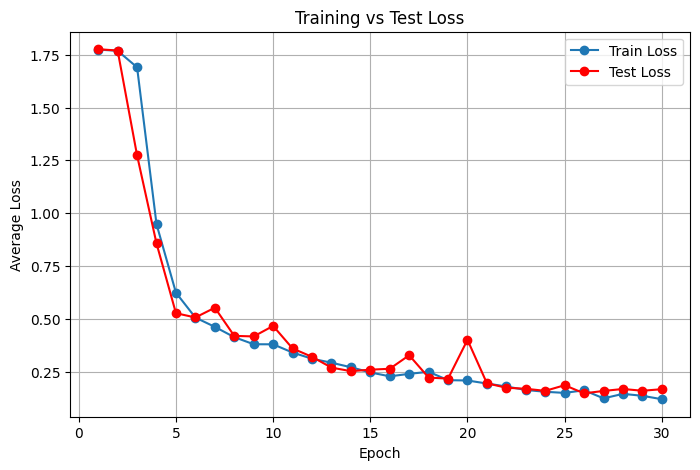

Test Accuracy: 0.9433

Testing params: n_heads=16, num_layers=3, model_dim=64
Epoch [1/30] | Train Loss: 1.7824 | Test Loss: 1.7732
Epoch [2/30] | Train Loss: 1.4964 | Test Loss: 1.0447
Epoch [3/30] | Train Loss: 0.7668 | Test Loss: 0.7290
Epoch [4/30] | Train Loss: 0.4601 | Test Loss: 0.3837
Epoch [5/30] | Train Loss: 0.3181 | Test Loss: 0.2742
Epoch [6/30] | Train Loss: 0.2379 | Test Loss: 0.2473
Epoch [7/30] | Train Loss: 0.1776 | Test Loss: 0.5722
Epoch [8/30] | Train Loss: 0.1859 | Test Loss: 0.1779
Epoch [9/30] | Train Loss: 0.1378 | Test Loss: 0.1220
Epoch [10/30] | Train Loss: 0.1249 | Test Loss: 0.1565
Epoch [11/30] | Train Loss: 0.1280 | Test Loss: 0.1798
Epoch [12/30] | Train Loss: 0.1134 | Test Loss: 0.1020
Epoch [13/30] | Train Loss: 0.1038 | Test Loss: 0.1065
Epoch [14/30] | Train Loss: 0.1096 | Test Loss: 0.1363
Epoch [15/30] | Train Loss: 0.0941 | Test Loss: 0.0977
Epoch [16/30] | Train Loss: 0.0950 | Test Loss: 0.0925
Epoch [17/30] | Train Loss: 0.0860 | Test Loss: 0.1

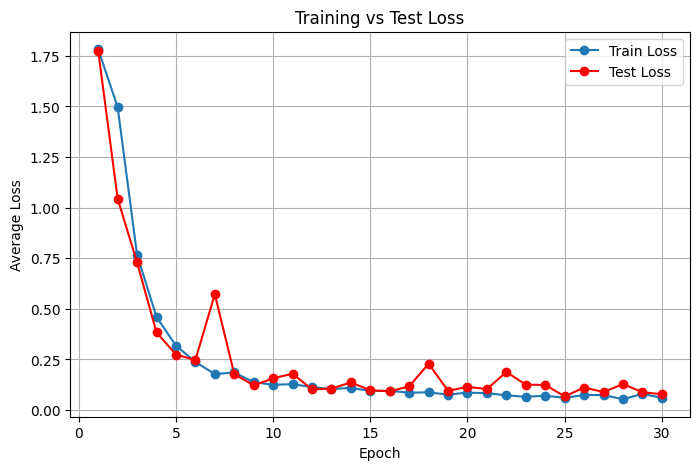

Test Accuracy: 0.9799

Testing params: n_heads=16, num_layers=3, model_dim=128
Epoch [1/30] | Train Loss: 1.7862 | Test Loss: 1.7727
Epoch [2/30] | Train Loss: 1.2651 | Test Loss: 0.7934
Epoch [3/30] | Train Loss: 0.5599 | Test Loss: 0.3813
Epoch [4/30] | Train Loss: 0.3021 | Test Loss: 0.2473
Epoch [5/30] | Train Loss: 0.2315 | Test Loss: 0.2545
Epoch [6/30] | Train Loss: 0.1893 | Test Loss: 0.3072
Epoch [7/30] | Train Loss: 0.1889 | Test Loss: 0.1731
Epoch [8/30] | Train Loss: 0.1425 | Test Loss: 0.2043
Epoch [9/30] | Train Loss: 0.1457 | Test Loss: 0.2291
Epoch [10/30] | Train Loss: 0.1529 | Test Loss: 0.1153
Epoch [11/30] | Train Loss: 0.1190 | Test Loss: 0.1213
Epoch [12/30] | Train Loss: 0.0970 | Test Loss: 0.1004
Epoch [13/30] | Train Loss: 0.1040 | Test Loss: 0.1429
Epoch [14/30] | Train Loss: 0.0976 | Test Loss: 0.0928
Epoch [15/30] | Train Loss: 0.0920 | Test Loss: 0.0879
Epoch [16/30] | Train Loss: 0.0941 | Test Loss: 0.0923
Epoch [17/30] | Train Loss: 0.1019 | Test Loss: 0.

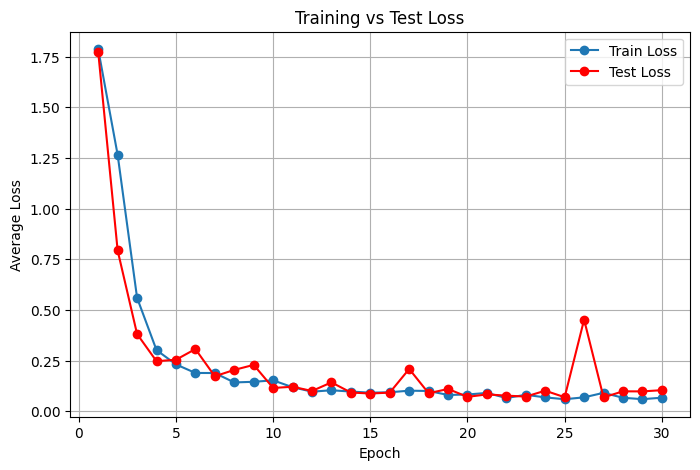

Test Accuracy: 0.9660

Testing params: n_heads=16, num_layers=3, model_dim=256
Epoch [1/30] | Train Loss: 1.8082 | Test Loss: 1.7729
Epoch [2/30] | Train Loss: 1.7830 | Test Loss: 1.7728
Epoch [3/30] | Train Loss: 1.4195 | Test Loss: 1.1901
Epoch [4/30] | Train Loss: 0.5737 | Test Loss: 0.4867
Epoch [5/30] | Train Loss: 0.2869 | Test Loss: 0.2179
Epoch [6/30] | Train Loss: 0.2242 | Test Loss: 0.2928
Epoch [7/30] | Train Loss: 0.2177 | Test Loss: 0.1771
Epoch [8/30] | Train Loss: 0.1599 | Test Loss: 0.1683
Epoch [9/30] | Train Loss: 0.1488 | Test Loss: 0.2447
Epoch [10/30] | Train Loss: 0.1498 | Test Loss: 0.1338
Epoch [11/30] | Train Loss: 0.1511 | Test Loss: 0.1240
Epoch [12/30] | Train Loss: 0.1717 | Test Loss: 0.1855
Epoch [13/30] | Train Loss: 0.1365 | Test Loss: 0.1196
Epoch [14/30] | Train Loss: 0.1329 | Test Loss: 0.2381
Epoch [15/30] | Train Loss: 0.1603 | Test Loss: 0.1190
Epoch [16/30] | Train Loss: 0.1398 | Test Loss: 0.1421
Epoch [17/30] | Train Loss: 0.1340 | Test Loss: 0.

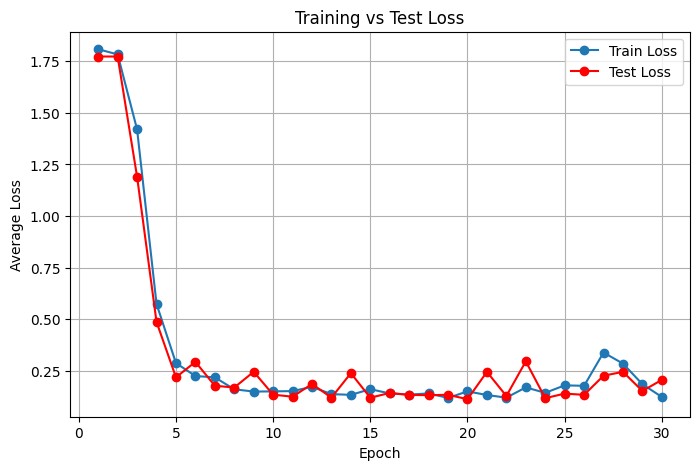

Test Accuracy: 0.9396

Testing params: n_heads=16, num_layers=4, model_dim=32
Epoch [1/30] | Train Loss: 1.7741 | Test Loss: 1.7709
Epoch [2/30] | Train Loss: 1.7695 | Test Loss: 1.7687
Epoch [3/30] | Train Loss: 1.7698 | Test Loss: 1.7677
Epoch [4/30] | Train Loss: 1.7671 | Test Loss: 1.7700
Epoch [5/30] | Train Loss: 1.7675 | Test Loss: 1.7607
Epoch [6/30] | Train Loss: 1.1882 | Test Loss: 0.8151
Epoch [7/30] | Train Loss: 0.6633 | Test Loss: 0.4467
Epoch [8/30] | Train Loss: 0.3993 | Test Loss: 0.3631
Epoch [9/30] | Train Loss: 0.3390 | Test Loss: 0.3174
Epoch [10/30] | Train Loss: 0.2770 | Test Loss: 0.2716
Epoch [11/30] | Train Loss: 0.2455 | Test Loss: 0.3975
Epoch [12/30] | Train Loss: 0.2368 | Test Loss: 0.1892
Epoch [13/30] | Train Loss: 0.1828 | Test Loss: 0.1995
Epoch [14/30] | Train Loss: 0.1852 | Test Loss: 0.1534
Epoch [15/30] | Train Loss: 0.1522 | Test Loss: 0.2154
Epoch [16/30] | Train Loss: 0.1650 | Test Loss: 0.1355
Epoch [17/30] | Train Loss: 0.1640 | Test Loss: 0.1

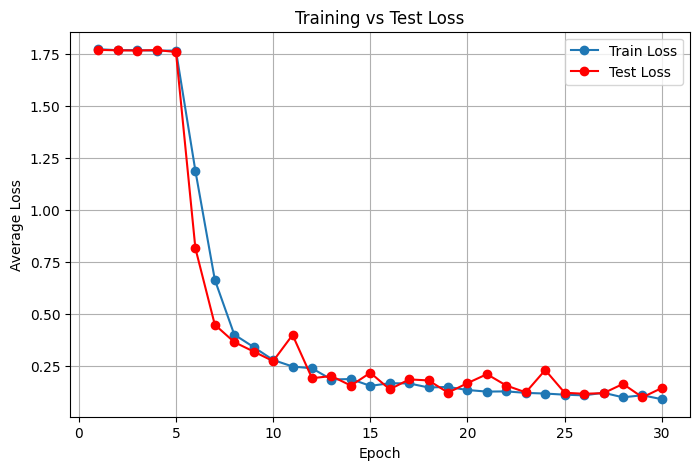

Test Accuracy: 0.9546

Testing params: n_heads=16, num_layers=4, model_dim=64
Epoch [1/30] | Train Loss: 1.7797 | Test Loss: 1.7674
Epoch [2/30] | Train Loss: 1.7709 | Test Loss: 1.7735
Epoch [3/30] | Train Loss: 1.4626 | Test Loss: 1.1829
Epoch [4/30] | Train Loss: 0.9061 | Test Loss: 0.8934
Epoch [5/30] | Train Loss: 0.4993 | Test Loss: 0.3410
Epoch [6/30] | Train Loss: 0.3726 | Test Loss: 0.3195
Epoch [7/30] | Train Loss: 0.2599 | Test Loss: 0.3114
Epoch [8/30] | Train Loss: 0.2482 | Test Loss: 0.2409
Epoch [9/30] | Train Loss: 0.1771 | Test Loss: 0.1621
Epoch [10/30] | Train Loss: 0.1852 | Test Loss: 0.1691
Epoch [11/30] | Train Loss: 0.1485 | Test Loss: 0.1186
Epoch [12/30] | Train Loss: 0.1538 | Test Loss: 0.1368
Epoch [13/30] | Train Loss: 0.1410 | Test Loss: 0.1689
Epoch [14/30] | Train Loss: 0.1180 | Test Loss: 0.3403
Epoch [15/30] | Train Loss: 0.1613 | Test Loss: 0.1196
Epoch [16/30] | Train Loss: 0.1006 | Test Loss: 0.1153
Epoch [17/30] | Train Loss: 0.1129 | Test Loss: 0.1

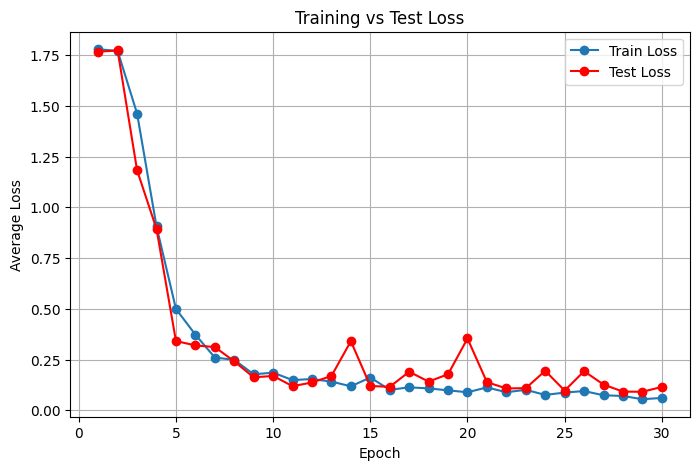

Test Accuracy: 0.9674

Testing params: n_heads=16, num_layers=4, model_dim=128
Epoch [1/30] | Train Loss: 1.7906 | Test Loss: 1.7864
Epoch [2/30] | Train Loss: 1.7748 | Test Loss: 1.7693
Epoch [3/30] | Train Loss: 1.2312 | Test Loss: 0.8738
Epoch [4/30] | Train Loss: 0.5097 | Test Loss: 0.4319
Epoch [5/30] | Train Loss: 0.3717 | Test Loss: 0.3221
Epoch [6/30] | Train Loss: 0.2594 | Test Loss: 0.1633
Epoch [7/30] | Train Loss: 0.2023 | Test Loss: 0.2593
Epoch [8/30] | Train Loss: 0.1488 | Test Loss: 0.1536
Epoch [9/30] | Train Loss: 0.1511 | Test Loss: 0.3091
Epoch [10/30] | Train Loss: 0.1265 | Test Loss: 0.2532
Epoch [11/30] | Train Loss: 0.1401 | Test Loss: 0.1742
Epoch [12/30] | Train Loss: 0.1237 | Test Loss: 0.1349
Epoch [13/30] | Train Loss: 0.1063 | Test Loss: 0.1073
Epoch [14/30] | Train Loss: 0.0986 | Test Loss: 0.1471
Epoch [15/30] | Train Loss: 0.1079 | Test Loss: 0.1475
Epoch [16/30] | Train Loss: 0.1204 | Test Loss: 0.1886
Epoch [17/30] | Train Loss: 0.0968 | Test Loss: 0.

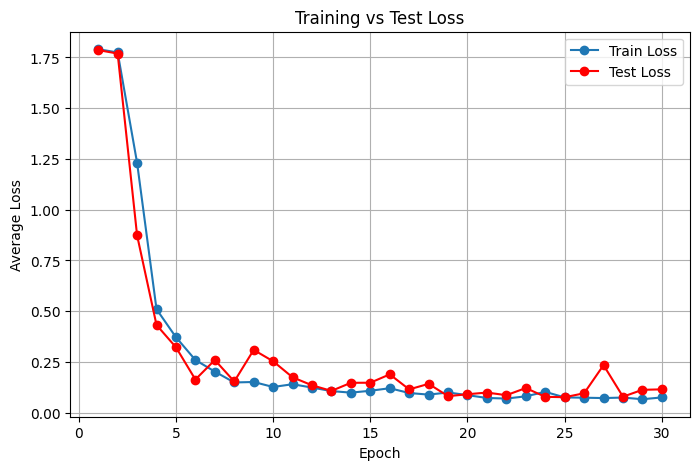

Test Accuracy: 0.9649

Testing params: n_heads=16, num_layers=4, model_dim=256
Epoch [1/30] | Train Loss: 1.8044 | Test Loss: 1.7672
Epoch [2/30] | Train Loss: 1.7804 | Test Loss: 1.7794
Epoch [3/30] | Train Loss: 1.7866 | Test Loss: 1.7760
Epoch [4/30] | Train Loss: 1.7841 | Test Loss: 1.7684
Epoch [5/30] | Train Loss: 1.7757 | Test Loss: 1.7692
Epoch [6/30] | Train Loss: 1.7757 | Test Loss: 1.7702
Epoch [7/30] | Train Loss: 1.7753 | Test Loss: 1.7715
Epoch [8/30] | Train Loss: 1.7717 | Test Loss: 1.7667
Epoch [9/30] | Train Loss: 1.7703 | Test Loss: 1.7711
Epoch [10/30] | Train Loss: 1.7689 | Test Loss: 1.7654
Epoch [11/30] | Train Loss: 1.7677 | Test Loss: 1.7754
Epoch [12/30] | Train Loss: 1.7671 | Test Loss: 1.7700
Epoch [13/30] | Train Loss: 1.7688 | Test Loss: 1.7670
Epoch [14/30] | Train Loss: 1.7678 | Test Loss: 1.7673
Epoch [15/30] | Train Loss: 1.7684 | Test Loss: 1.7675
Epoch [16/30] | Train Loss: 1.7666 | Test Loss: 1.7672
Epoch [17/30] | Train Loss: 1.7674 | Test Loss: 1.

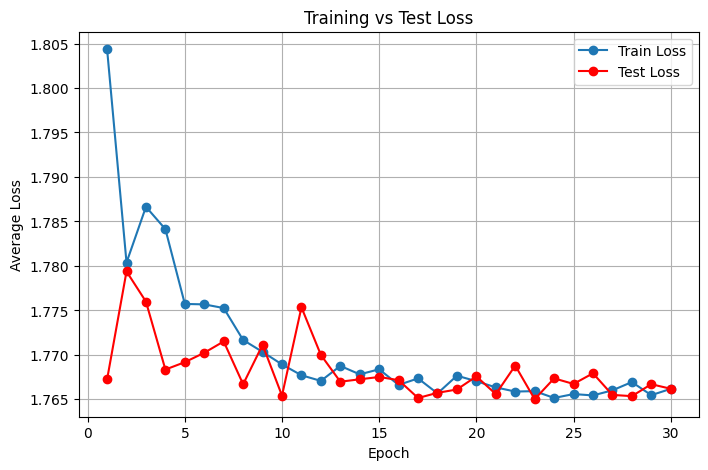

Test Accuracy: 0.2159

Beste Hyperparameter-Kombination:  (16, 2, 128, 0.9886571533113795)


In [6]:
# ---- GRID SEARCH (Bereits durchgeführt - nur zur Dokumentation)----

params = {
    "n_heads": [2, 4, 8, 16],  # Es muss gelten model_dim % n_heads = 0 
    "num_layers": [1, 2, 3, 4],
    "model_dim": [32, 64, 128, 256]
}

param_combi = list(product(
    params["n_heads"],
    params["num_layers"],
    params["model_dim"]
))

results = []

for n_heads, num_layers, model_dim in param_combi:
    if model_dim % n_heads != 0:
        continue
        
    print(f"\nTesting params: n_heads={n_heads}, num_layers={num_layers}, model_dim={model_dim}")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = TimeSeriesTransformer(input_dim=128, num_classes=6, model_dim=model_dim, n_heads=n_heads, num_layers=num_layers)
    model.train_model(train_loader, test_loader, epochs=30)

    acc = model.evaluate(test_loader)
    results.append((n_heads, num_layers, model_dim, acc))
    torch.cuda.empty_cache()

best = max(results, key=lambda x: x[-1])
print("\nBeste Hyperparameter-Kombination: ", best)

In [ ]:
# Old params: (4, 2, 64) 